In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import glob
import os
import pickle
import random

import dask
import dask.array as da
import geopandas
import learn2map.raster_tools as rt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import tensorflow as tf
import xarray as xr
from a2105_global100.ml_functions import (
    data_cnn_prediction,
    densenet_model,
    density_scatter_plot,
    load_tf,
    regression_tfrecord_from_df,
    residual2_box_plot,
    residual_box_plot,
)
from geocube.api.core import make_geocube
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

os.environ["GDAL_MAX_DATASET_POOL_SIZE"] = "999"

s3_path = "s3://ctrees-development/agb_30m_mex"
#os.chdir("/data/gedi_1km")


2024-10-21 12:11:23.070069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 12:11:23.967896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ray/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/ray/anaconda3/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install das

Num GPUs Available:  1


2024-10-21 12:11:25.891346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-21 12:11:25.928439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-21 12:11:25.932070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
# Define the S3 path
s3_path2 = "s3://ctrees-development/tree_height_30m_mex/test"


In [3]:
def raster_adding_yxgrid(
    darr,
    y_lat,
    x_lon,
    block_info=None,
):
    id_y = block_info[0]["array-location"][1]
    id_x = block_info[0]["array-location"][2]
    # x0, _ = geotfm * [np.arange(id_x[0], id_x[1]) + 0.5, 0.5]
    # _, y0 = geotfm * [0.5, np.arange(id_y[0], id_y[1]) + 0.5]
    x0 = x_lon[id_x[0] : id_x[1]]
    y0 = y_lat[id_y[0] : id_y[1]]
    xv, yv = np.meshgrid(x0, y0)
    img_stack = np.concatenate([darr, yv[None, :, :], xv[None, :, :]], axis=0)
    return img_stack


def mosaic_adding_yxgrid(xarr0, chunk_size=3000):
    xarr0 = xarr0.chunk(chunks=(xarr0.shape[0], chunk_size, chunk_size))
    out_chunks = (xarr0.shape[0] + 2, xarr0.chunks[1], xarr0.chunks[2])
    darr_out = xarr0.data.map_blocks(
        raster_adding_yxgrid,
        xarr0.y.values,
        xarr0.x.values,
        chunks=out_chunks,
        meta=np.array(()),
    )
    new_coords = [
        ("band", xarr0.band.values.tolist() + ["y_grid", "x_grid"]),
        ("y", xarr0.y.values),
        ("x", xarr0.x.values),
    ]
    xarr_out = xr.DataArray(darr_out, coords=new_coords, dims=xarr0.dims)
    return xarr_out


def extract_training_lst(
    i,
    tiles0,
    tiles1,
    scale=1,  # scale is the size ratio of tiles1 vs. tiles0
    width=1,
    valid_range=(0, 9999),
    mask_band=0,
    target_bands=[0],
    out_path=None,
):
    dims0 = tiles0.shape
    dims1 = tiles1.shape
    # print(dims0)
    # print(dims1)
    n_arr = np.arange(dims0[1] * dims0[2])
    mask_arr = tiles0[mask_band, :, :]
    mask_arr = np.where((mask_arr > valid_range[0]) & (mask_arr < valid_range[1]), 1, 0)
    valid_idx = n_arr[mask_arr.ravel().astype(bool)]

    if len(valid_idx) > 0:
        # print(len(valid_idx))
        sample0_lst = []
        sample1_lst = []
        for i in valid_idx:
            row, col = np.unravel_index(i, (dims0[1], dims0[2]))
            # print([row, col])
            sample_i = tiles0[
                :,
                row : row + 1,
                col : col + 1,
            ]
            sample0_lst.append(
                np.transpose(sample_i, [1, 2, 0])
            )  # transpose to [y, x, band]
            sample_i = tiles1[
                :,
                row * scale + width // 2 : row * scale + width * 3 // 2,
                col * scale + width // 2 : col * scale + width * 3 // 2,
            ]
            # print(np.transpose(sample_i, [1, 2, 0]).shape)
            sample1_lst.append(
                np.transpose(sample_i, [1, 2, 0])
            )  # transpose to [y, x, band]
        valid_target = np.stack(sample0_lst, axis=0)
        valid_sample = np.stack(sample1_lst, axis=0)

        band_list = np.arange(dims0[0])
        y_bands = np.isin(band_list, target_bands)
        if y_bands.any():
            y_lst = valid_target[:, 0, 0, y_bands]

        X_lst = valid_sample[:, :, :, np.arange(dims1[0])]

        pickle.dump([X_lst, y_lst], open(f"{out_path}_{i}", "wb"))
        return f"{out_path}_{i}"
        # else:
        # X_lst = np.empty([0, width, width, len(X_bands)])
        # y_lst = np.empty([0, len(y_bands)])


def get_layers_xy(
    xarr0,
    xarr1,
    scale,
    width,
    mask_band,
    target_bands,
    valid_range=(0, 9999),
    out_path=None,
):
    # Make sure xarr0/xarr1 have the same chunks
    darr0 = da.overlap.overlap(xarr0.data, depth=(0, 0, 0), boundary="nearest")
    darr1 = da.overlap.overlap(xarr1.data, depth=(0, width, width), boundary="nearest")
    tiles0 = darr0.to_delayed().ravel()
    tiles1 = darr1.to_delayed().ravel()
    results = [
        dask.delayed(extract_training_lst)(
            i,
            tiles0[i],
            tiles1[i],
            scale=scale,
            width=width,
            valid_range=valid_range,
            mask_band=mask_band,
            target_bands=target_bands,
            out_path=out_path,
        )
        for i in range(len(tiles0))
    ]
    return results


def build_vrt_mosaic(in_file, out_file):
    in_fname = "merge_list.txt"
    with open(in_fname, "w") as f:
        f.writelines("%s\n" % i for i in in_file)
    command = f"gdalbuildvrt -overwrite -input_file_list {in_fname} {out_file}"
    print(command)
    output = os.system(command)
    print(output)

In [7]:
# File list for the new RH mosaics
file_lst_rh = [
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh75/RH75_30m_densenet_l1_rh75_mosaic.tif",
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh98_v2/RH98_30m_densenet_l1_rh98_v2_mosaic.tif",
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh90/RH90_30m_densenet_l1_rh90_mosaic.tif",
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh50/RH50_30m_densenet_l1_rh50_mosaic.tif"
]

# The list of corresponding variable names for these layers
name_lst_rh = [
    "rh75_30m_mx",
    "rh98_30m_mx",
    "rh90_30m_mx",
    "rh50_30m_mx"
]

# Iterate over the files and create the VRTs
for ii in range(len(name_lst_rh)):
    path_vrt = f"./test/test_layers_{name_lst_rh[ii]}.vrt"
    in_fname = f"merge_list_{name_lst_rh[ii]}.txt"
    
    # Write the file paths to the text file
    with open(in_fname, "w") as f:
        f.writelines("%s\n" % file_lst_rh[ii])
    
    # Build the VRT using the file list
    band_name = rt.build_stack_vrt(in_fname, path_vrt)
    print(f"VRT for {name_lst_rh[ii]} created at {path_vrt}")

['RH75_30m_densenet_l1_rh75_mosaic_b1']
VRT for rh75_30m_mx created at ./test/test_layers_rh75_30m_mx.vrt
['RH98_30m_densenet_l1_rh98_v2_mosaic_b1']
VRT for rh98_30m_mx created at ./test/test_layers_rh98_30m_mx.vrt
['RH90_30m_densenet_l1_rh90_mosaic_b1']
VRT for rh90_30m_mx created at ./test/test_layers_rh90_30m_mx.vrt
['RH50_30m_densenet_l1_rh50_mosaic_b1']
VRT for rh50_30m_mx created at ./test/test_layers_rh50_30m_mx.vrt


In [32]:
!gdalinfo /vsis3/ctrees-development/tree_height_30m_mex/test_rh75/RH75_30m_densenet_l1_rh75_mosaic.tif

Driver: GTiff/GeoTIFF
Files: /vsis3/ctrees-development/tree_height_30m_mex/test_rh75/RH75_30m_densenet_l1_rh75_mosaic.tif
Size is 123223, 74214
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-117.419250000000005,32.726999999999997)
Pixel Size = (0.000250000000000,-0.000250000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
  LAYOUT=COG
  PREDICTOR=2
Corner Coordinates:
Upper Left  (-117.4192500,  32.7270000) (117d2

In [8]:
# Corrected file list with /vsis3/ prefix for accessing S3 paths
file_lst_rh = [
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh75/RH75_30m_densenet_l1_rh75_mosaic.tif",
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh98_v2/RH98_30m_densenet_l1_rh98_v2_mosaic.tif",
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh90/RH90_30m_densenet_l1_rh90_mosaic.tif",
    "/vsis3/ctrees-development/tree_height_30m_mex/test_rh50/RH50_30m_densenet_l1_rh50_mosaic.tif"
]

# Create a single VRT for all the layers
path_vrt = "./test/test_layers_rh.vrt"
in_fname = "merge_list_rh.txt"

# Write the paths to a single file for all the layers
with open(in_fname, "w") as f:
    f.writelines("%s\n" % file for file in file_lst_rh)

# Build the VRT from all the files
band_name = rt.build_stack_vrt(in_fname, path_vrt)
print(f"Single stacked VRT created at {path_vrt}")

['RH75_30m_densenet_l1_rh75_mosaic_b1', 'RH98_30m_densenet_l1_rh98_v2_mosaic_b1', 'RH90_30m_densenet_l1_rh90_mosaic_b1', 'RH50_30m_densenet_l1_rh50_mosaic_b1']
Single stacked VRT created at ./test/test_layers_rh.vrt


In [7]:
# Corrected file list with /vsis3/ prefix for accessing S3 paths
file_lst_ndvi = [
    "/vsis3/ctrees-input-data/tree_height/Mexico/NDVI_30m/mosaic/ndvi_int_30m_mex.tif"
]

# Create a VRT for the NDVI layer
path_vrt = "./test/test_layer_ndvi.vrt"
in_fname = "merge_list_ndvi.txt"

# Write the NDVI path to a file
with open(in_fname, "w") as f:
    f.writelines("%s\n" % file for file in file_lst_ndvi)

# Build the VRT for the NDVI file (no stacking necessary)
band_name = rt.build_stack_vrt(in_fname, path_vrt)
print(f"VRT for NDVI created at {path_vrt}")

['ndvi_int_30m_mex_b1']
VRT for NDVI created at ./test/test_layer_ndvi.vrt


In [8]:
# Configure Dask to use a specific number of threads if needed
dask.config.set({"num_workers": 4})

# Define the input VRT path and output S3 path
input_vrt_path = "test/test_layers_rh.vrt"  # Use the new combined VRT
output_zarr_path = f"{s3_path}/test_layers_rh2.zarr"

# Open the raster data with chunking
da1 = rioxarray.open_rasterio(input_vrt_path, chunks=(1, 2000, 2000), lock=False).astype("float32")

# Handle NaN values
da1 = da1.fillna(np.nan)

# Set the CRS if not already present
da1.rio.write_crs("EPSG:4326", inplace=True)

# Create an xarray Dataset from the raster data
ds = xr.Dataset({"da": da1})

# Write the dataset to Zarr format
ds.to_zarr(output_zarr_path, mode="w")

print("Zarr file written successfully to", output_zarr_path)

Zarr file written successfully to s3://ctrees-development/agb_30m_mex/test_layers_rh2.zarr


In [7]:
import dask
import rioxarray
import numpy as np
import xarray as xr

# Configure Dask to use a specific number of threads if needed
dask.config.set({"num_workers": 4})

# Define the input VRT path and output S3 path
input_vrt_path = "test/test_layer_ndvi.vrt"  # Use the NDVI VRT created earlier
output_zarr_path = f"{s3_path}/ndvi_int_30m_mex.zarr"

# Open the raster data with chunking
da1 = rioxarray.open_rasterio(input_vrt_path, chunks=(1, 2000, 2000), lock=False).astype("float32")

# Handle NaN values
da1 = da1.fillna(np.nan)

# Set the CRS if not already present
da1.rio.write_crs("EPSG:4326", inplace=True)

# Create an xarray Dataset from the raster data
ds = xr.Dataset({"da": da1})

# Write the dataset to Zarr format
ds.to_zarr(output_zarr_path, mode="w")

print("Zarr file written successfully to", output_zarr_path)

Zarr file written successfully to s3://ctrees-development/agb_30m_mex/ndvi_int_30m_mex.zarr


In [7]:
import dask
import rioxarray
import xarray as xr
import numpy as np

# Configure Dask to use a specific number of threads if needed
dask.config.set({"num_workers": 4})

# Define the input raster path (directly from S3) and output Zarr path
input_raster_path = "s3://ctrees-development/agb_30m_mex/mexico_reference_30m.tif"  # Use the new raster file
output_zarr_path = f"{s3_path}/mexico_reference_30m.zarr"

# Open the raster data with chunking
da1 = rioxarray.open_rasterio(input_raster_path, chunks=(1, 2000, 2000), lock=False).astype("float32")

# Handle NaN values
da1 = da1.fillna(np.nan)

# Set the CRS if not already present
da1.rio.write_crs("EPSG:4326", inplace=True)

# Create an xarray Dataset from the raster data
ds = xr.Dataset({"da": da1})

# Write the dataset to Zarr format
ds.to_zarr(output_zarr_path, mode="w")

print("Zarr file written successfully to", output_zarr_path)

Zarr file written successfully to s3://ctrees-development/agb_30m_mex//mexico_reference_30m.zarr


In [6]:
s3_path

's3://ctrees-development/agb_30m_mex'

In [ ]:
'''
path_csv = f"{s3_path}/mexico.csv"
df1 = pd.read_csv(path_csv)
gdf1 = geopandas.GeoDataFrame(
    df1, geometry=geopandas.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326"
)
ref_tif = f"{s3_path}/mexico_reference_30m.tif"
da1_ref = xr.open_zarr(f"{s3_path}/mexico_reference_30m.zarr")["da"]
da0 = xr.open_rasterio(ref_tif)
da1 = make_geocube(
    vector_data=gdf1,
    measurements=["agb"],
    like=da0,
)["agb"]
da1 = da1.expand_dims({"band": ["target"]}, axis=0)
da1["y"] = da1_ref.y.values
da1["x"] = da1_ref.x.values
da1 = da1.fillna(np.nan)
'''

## Field data for calibration

In [13]:
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np

#path_csv = f"{s3_path}/mexico.csv"
path_csv = f"{s3_path}/mexico_infys_c3_filtered6.csv"
df1 = pd.read_csv(path_csv)
gdf1 = gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326"
)

ref_tif = f"{s3_path}/mexico_reference_30m.tif"
da1_ref = xr.open_zarr(f"{s3_path}/mexico_reference_30m.zarr")["da"]
da0 = rioxarray.open_rasterio(ref_tif)  # Use rioxarray to open the TIFF file
da1 = make_geocube(
    vector_data=gdf1,
    measurements=["agb"],
    like=da0,
)["agb"]
da1 = da1.expand_dims({"band": ["target"]}, axis=0)
da1["y"] = da1_ref.y.values
da1["x"] = da1_ref.x.values
da1 = da1.fillna(np.nan)

In [ ]:

ds = xr.Dataset({"da": da1})
ds.to_zarr(f"{s3_path}/test_layers_agb_v8_mx.zarr", mode="w")

In [6]:
# Calculate the resolution
x_resolution = ds['x'].diff('x').mean().values
y_resolution = ds['y'].diff('y').mean().values

print(f"X resolution: {x_resolution} degrees")
print(f"Y resolution: {y_resolution} degrees")

X resolution: 0.00024999999999999567 degrees
Y resolution: -0.00025000000000000017 degrees


In [ ]:
output_zarr_path = f"{s3_path}/test_layers_rh.zarr"

# Open the raster data with chunking
da1 = rioxarray.open_rasterio(input_vrt_path, chunks=(1, 2000, 2000), lock=False).astype("float32")

# Handle NaN values
da1 = da1.fillna(np.nan)

# Set the CRS if not already present
da1.rio.write_crs("EPSG:4326", inplace=True)

# Create an xarray Dataset from the raster data
ds = xr.Dataset({"da": da1})

# Write the dataset to Zarr format
ds.to_zarr(output_zarr_path, mode="w")

print("Zarr file written successfully to", output_zarr_path)

In [6]:
ds1 = xr.open_zarr(f"{s3_path2}/xlayers_combine_30m.zarr")["da"].astype("float32").chunk({"x": 500, "y": 500})

In [7]:
crs = "EPSG:4326" 
ds1.rio.write_crs(crs, inplace=True)

<xarray.DataArray 'da' (band: 8, y: 74215, x: 123224)> Size: 293GB
dask.array<rechunk-merge, shape=(8, 74215, 123224), dtype=float32, chunksize=(8, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 64B 1 1 2 3 4 5 1 2
  * x            (x) float64 986kB -117.4 -117.4 -117.4 ... -86.61 -86.61 -86.61
  * y            (y) float64 594kB 32.73 32.73 32.73 32.73 ... 14.17 14.17 14.17
    spatial_ref  int64 8B 0
Attributes:
    grid_mapping:  spatial_ref

In [9]:
import xarray as xr
import rioxarray as rioxr
from rasterio.enums import Resampling

ds4 = xr.open_zarr(f"{s3_path}/test_layers_rh.zarr")["da"].astype("float32").chunk({"x": 500, "y": 500}) 
ds4.rio.write_crs(crs, inplace=True)
ds4 = ds4.rio.reproject_match(ds1, resampling=Resampling.nearest)  # Use Resampling.nearest

In [10]:
# Combine all datasets along the 'band' dimension
combined_ds = xr.concat([ds1, ds4], dim="band")

In [11]:
combined_ds

<xarray.DataArray 'da' (band: 12, y: 74215, x: 123224)> Size: 439GB
dask.array<concatenate, shape=(12, 74215, 123224), dtype=float32, chunksize=(8, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 96B 1 1 2 3 4 5 1 2 1 2 3 4
  * x            (x) float64 986kB -117.4 -117.4 -117.4 ... -86.61 -86.61 -86.61
  * y            (y) float64 594kB 32.73 32.73 32.73 32.73 ... 14.17 14.17 14.17
    spatial_ref  int64 8B 0
Attributes:
    grid_mapping:  spatial_ref

In [ ]:

import xarray as xr
import rioxarray as rioxr
from rasterio.enums import Resampling

# Define the S3 path
#s3_path2 = "s3://ctrees-development/tree_height_30m_mex/test"

# Open Zarr datasets using xarray and cast to float32
#ds1 = xr.open_zarr(f"{s3_path2}/test_layers_dem_30m_mx.zarr")["da"].astype("float32").chunk({"x": 500, "y": 500})
#ds2 = xr.open_zarr(f"{s3_path2}/test_layers_hls_30m_mx.zarr")["da"].astype("float32").chunk({"x": 500, "y": 500})
#ds3 = xr.open_zarr(f"{s3_path2}/test_layers_alos_30m_mx.zarr")["da"].astype("float32").chunk({"x": 500, "y": 500})
#ds4 = xr.open_zarr(f"{s3_path}/test_layers_rh.zarr")["da"].astype("float32").chunk({"x": 500, "y": 500}) 

# Set CRS for each dataset (replace 'EPSG:4326' with the actual CRS if different)
#crs = "EPSG:4326"  # Example CRS, adjust if needed
#ds1.rio.write_crs(crs, inplace=True)
#ds2.rio.write_crs(crs, inplace=True)
#ds3.rio.write_crs(crs, inplace=True)
#ds4.rio.write_crs(crs, inplace=True)


# Reproject ds3 (ALOS) to match ds1
#ds4 = ds4.rio.reproject_match(ds1, resampling=Resampling.nearest)  # Use Resampling.nearest

# Combine all datasets along the 'band' dimension
combined_ds = xr.concat([ds1, ds4], dim="band")

# Chunk the combined dataset
combined_ds = combined_ds.chunk({"band": -1, "x": 500, "y": 500})


In [4]:
s3_path

's3://ctrees-development/agb_30m_mex'

In [25]:
# Write CRS and chunk the combined dataset
combined_ds = combined_ds.rio.write_crs("EPSG:4326")
combined_ds = combined_ds.chunk({"x": 500, "y": 500})
combined_ds.attrs = {}

# Remove the grid_mapping attribute from the DataArray
combined_ds.attrs.pop('grid_mapping', None)

# Save the combined dataset to a Zarr store
ds = xr.Dataset({"da": combined_ds})

# Remove chunks encoding before saving if it exists
if "chunks" in ds.da.encoding:
    del ds.da.encoding["chunks"]

# Save to Zarr
ds.to_zarr(f"{s3_path}/xlayers_combine3_30m.zarr", mode="w")

# Print the final dataset
ds

<xarray.Dataset> Size: 439GB
Dimensions:      (band: 12, x: 123224, y: 74215)
Coordinates:
  * band         (band) int64 96B 1 1 2 3 4 5 1 2 1 2 3 4
  * x            (x) float64 986kB -117.4 -117.4 -117.4 ... -86.61 -86.61 -86.61
  * y            (y) float64 594kB 32.73 32.73 32.73 32.73 ... 14.17 14.17 14.17
    spatial_ref  int64 8B 0
Data variables:
    da           (band, y, x) float32 439GB dask.array<chunksize=(8, 500, 500), meta=np.ndarray>

## Combine predictors

In [27]:
s3_path = "s3://ctrees-development/agb_30m_mex"

In [5]:
outname = "test/mexico_agb/agb_30m"
os.makedirs(outname, exist_ok=True)

pix_size = 0.00022457882102988513
offsets = 0.00005 + pix_size * 2.5
width = 7

In [6]:
path_tif = f"{s3_path}/test_layers_agb_v8_mx.zarr"
da0 = xr.open_zarr(path_tif)["da"].chunk((-1, 1000, 1000))
da0

/tmp/ipykernel_14634/885057556.py:2: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  da0 = xr.open_zarr(path_tif)["da"].chunk((-1, 1000, 1000))


<xarray.DataArray 'da' (band: 1, y: 74215, x: 123224)> Size: 73GB
dask.array<rechunk-merge, shape=(1, 74215, 123224), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 8B 'target'
    spatial_ref  int64 8B ...
  * x            (x) float64 986kB -117.4 -117.4 -117.4 ... -86.61 -86.61 -86.61
  * y            (y) float64 594kB 32.73 32.73 32.73 32.73 ... 14.17 14.17 14.17
Attributes:
    long_name:  agb
    name:       agb

In [7]:
path_tif = f"{s3_path}/xlayers_combine3_30m.zarr"
#path_tif = f"{s3_path2}/xlayers_combine_30m.zarr"
da1 = xr.open_zarr(path_tif)["da"].chunk((-1, 1000, 1000))

da1

/tmp/ipykernel_14634/1685926172.py:3: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  da1 = xr.open_zarr(path_tif)["da"].chunk((-1, 1000, 1000))


<xarray.DataArray 'da' (band: 12, y: 74215, x: 123224)> Size: 439GB
dask.array<rechunk-merge, shape=(12, 74215, 123224), dtype=float32, chunksize=(12, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 96B 1 1 2 3 4 5 1 2 1 2 3 4
  * x        (x) float64 986kB -117.4 -117.4 -117.4 ... -86.61 -86.61 -86.61
  * y        (y) float64 594kB 32.73 32.73 32.73 32.73 ... 14.17 14.17 14.17
Attributes:
    grid_mapping:  spatial_ref

In [8]:
# Get chunk sizes (tiles) from da0 and da1
tiles1 = list(da0.chunks)  # Chunks of da0
tiles1 = list(da1.chunks)  # Chunks of da1



In [9]:
print(da0.rio.resolution())
print(da1.rio.resolution())

print(da1.shape[2] / da0.shape[2])

(0.00025, -0.00025)
(0.00025, -0.00025)
1.0


In [31]:
results = get_layers_xy(
    da0,
    da1,
    scale=1,
    width=width,
    mask_band=0,
    target_bands=[0],
    valid_range=(0, 700),
    out_path=f"{outname}/training_samples",
)

computed = dask.compute(*results)

In [10]:

# read data
files_15 = glob.glob(f"{outname}/training_samples*")
X_15_lst = []
y_15_lst = []
for ifile in files_15:
    X_lst, y_lst = pickle.load(open(ifile, "rb"))
    # os.remove(ifile)
    X_15_lst.append(X_lst)
    y_15_lst.append(y_lst)
X_15 = np.concatenate(X_15_lst, axis=0)
y_15 = np.concatenate(y_15_lst, axis=0)


In [11]:

valid_idx = ~np.isnan(X_15.reshape(X_15.shape[0], -1)).any(axis=1)
X_15 = X_15[valid_idx]
y_15 = y_15[valid_idx]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_15, y_15[:, 0], test_size=0.2, random_state=44
)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=55
)

(2470, 7, 7, 12)
(2470,)


(array([608., 227., 146., 311., 268., 213., 201., 190., 161., 150., 180.,
        186., 150., 148., 107.,  92.,  75.,  86.,  61.,  52.,  31.,  39.,
         36.,  20.,  25.,  11.,  19.,   9.,   8.,   8.,   9.,   4.,   8.,
          6.,   1.,   3.,   4.,   2.,   2.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([3.22584550e-02, 6.96278759e+00, 1.38933167e+01, 2.08238458e+01,
        2.77543750e+01, 3.46849041e+01, 4.16154332e+01, 4.85459624e+01,
        5.54764915e+01, 6.24070206e+01, 6.93375498e+01, 7.62680789e+01,
        8.31986080e+01, 9.01291372e+01, 9.70596663e+01, 1.03990195e+02,
        1.10920725e+02, 1.17851254e+02, 1.24781783e+02, 1.31712312e+02,
        1.38642841e+02, 1.45573370e+02, 1.52503899e+02, 1.59434428e+02,
        1.66364958e+02, 1.73295487e+02, 1.80226016e+02, 1.87156545e+02,
        1.94087074e+02, 2.01017603e+02, 2.07948132e+02, 2.14878662e+02,
        2.21809191e+02, 2.28739720e+02, 2.35670249e+02, 2.42600778e+02,
        2.

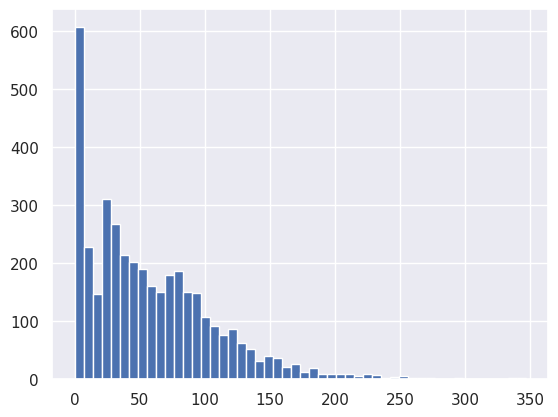

In [13]:
print(X_train.shape)
print(y_train.shape)
plt.hist(y_15[:, 0], bins=50)

In [14]:
X_train

array([[[[2.216e+03, 1.021e+03, 2.121e+03, ..., 4.600e+01, 2.500e+01,
          2.000e+00],
         [2.217e+03, 9.780e+02, 2.080e+03, ..., 4.400e+01, 2.500e+01,
          2.000e+00],
         [2.219e+03, 1.011e+03, 2.123e+03, ..., 5.200e+01, 2.700e+01,
          2.000e+00],
         ...,
         [2.221e+03, 8.870e+02, 2.024e+03, ..., 4.500e+01, 2.700e+01,
          2.000e+00],
         [2.222e+03, 8.840e+02, 2.019e+03, ..., 4.400e+01, 2.600e+01,
          2.000e+00],
         [2.224e+03, 8.360e+02, 1.934e+03, ..., 4.700e+01, 2.700e+01,
          2.000e+00]],

        [[2.215e+03, 8.920e+02, 2.020e+03, ..., 4.600e+01, 2.800e+01,
          2.000e+00],
         [2.216e+03, 8.620e+02, 2.023e+03, ..., 5.400e+01, 3.000e+01,
          2.000e+00],
         [2.217e+03, 8.400e+02, 2.044e+03, ..., 6.100e+01, 3.600e+01,
          4.000e+00],
         ...,
         [2.220e+03, 7.640e+02, 1.954e+03, ..., 5.200e+01, 2.900e+01,
          3.000e+00],
         [2.224e+03, 7.670e+02, 1.950e+03, ..., 4.

In [41]:

# Function to serialize a single example of features and label
def serialize_example(feature, label):
    feature = feature.flatten()  # Flatten the multi-dimensional feature to 1D
    feature_dict = {
        "features": tf.train.Feature(float_list=tf.train.FloatList(value=feature)),
        "label": tf.train.Feature(float_list=tf.train.FloatList(value=[label])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example_proto.SerializeToString()


with tf.io.TFRecordWriter(f"{outname}/tf_training.tfrecord") as writer:
    for feature, label in zip(X_train, y_train):
        serialized_example = serialize_example(feature, label)
        writer.write(serialized_example)
with tf.io.TFRecordWriter(f"{outname}/tf_eval.tfrecord") as writer:
    for feature, label in zip(X_eval, y_eval):
        serialized_example = serialize_example(feature, label)
        writer.write(serialized_example)
with tf.io.TFRecordWriter(f"{outname}/tf_test.tfrecord") as writer:
    for feature, label in zip(X_test, y_test):
        serialized_example = serialize_example(feature, label)
        writer.write(serialized_example)



In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
BATCH_SIZE_TEST = 32
width = 7
nbands = 12
n_train = y_train.shape[0]

In [16]:
# Read the TFRecord file
def parse_function(example_proto):
    feature_description = {
        "features": tf.io.FixedLenFeature(
            [width * width * nbands], tf.float32
        ),  # Must match the flattened shape
        "label": tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    parsed_features["features"] = tf.reshape(
        parsed_features["features"], (width, width, nbands)
    )  # Reshape back to original shape
    return parsed_features["features"], parsed_features["label"]


train_dataset = tf.data.TFRecordDataset(f"{outname}/tf_training.tfrecord").map(
    parse_function
)
eval_dataset = tf.data.TFRecordDataset(f"{outname}/tf_eval.tfrecord").map(
    parse_function
)
test_dataset = tf.data.TFRecordDataset(f"{outname}/tf_test.tfrecord").map(
    parse_function
)

2024-10-21 12:12:51.119405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-21 12:12:51.123435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-21 12:12:51.126817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
# Find mean/std of training data
SAMPLE_N = 50000
X_list = []
y_list = []
for X, Y in train_dataset.shuffle(buffer_size=200000).take(SAMPLE_N):
    X_list.append(X.numpy())
    y_list.append(Y.numpy())
X_all = np.stack(X_list, axis=0)
y_all = np.stack(y_list, axis=0)
X_mean = np.nanmean(X_all.reshape(-1, nbands), axis=0).tolist()
X_std = np.nanstd(X_all.reshape(-1, nbands), axis=0).tolist()
Y_mean = np.nanmean(y_all.reshape(-1, 1), axis=0).tolist()
Y_std = np.nanstd(y_all.reshape(-1, 1), axis=0).tolist()
print(f"X_mean: {X_mean}")
print(f"X_std: {X_std}")
print(f"y_mean: {Y_mean}")
print(f"y_std: {Y_std}")

X_mean: [1434.0963134765625, 648.7952880859375, 2379.059326171875, 2028.9459228515625, 1235.5584716796875, 2767.029296875, 0.0, 3238.29638671875, 66.34403991699219, 119.33314514160156, 87.48179626464844, 35.6134033203125]
X_std: [950.9837036132812, 442.7490539550781, 575.7389526367188, 671.6898803710938, 652.62060546875, 1074.8470458984375, 0.0, 1047.1123046875, 52.992462158203125, 62.49066925048828, 57.165653228759766, 35.600521087646484]
y_mean: [57.56835174560547]
y_std: [48.5778694152832]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 12)]        0         
                                                                 
 dense_net (DenseNet)        (None, 7, 7, 112)         57280     
                                                                 
 global_average_pooling2d (  (None, 112)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                7232      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 64577 (252.25 KB)
Trainable params: 62145 (242.75 KB)
Non-trainable params: 2432 (9.50 KB)
______________________

2024-10-19 12:07:38.050480: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open test/mexico_agb/agb_30m_densenet_l1_ckpt: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


19/19 [==============================] - 8s 122ms/step - loss: 0.4526 - root_mean_squared_error: 0.5363 - val_loss: 0.5271 - val_root_mean_squared_error: 0.6564
Epoch 2/100
19/19 [==============================] - 2s 90ms/step - loss: 0.4479 - root_mean_squared_error: 0.5516 - val_loss: 0.4912 - val_root_mean_squared_error: 0.5863
Epoch 3/100
19/19 [==============================] - 2s 87ms/step - loss: 0.4220 - root_mean_squared_error: 0.5073 - val_loss: 0.4727 - val_root_mean_squared_error: 0.5578
Epoch 4/100
19/19 [==============================] - 2s 84ms/step - loss: 0.4309 - root_mean_squared_error: 0.5044 - val_loss: 0.4690 - val_root_mean_squared_error: 0.5480
Epoch 5/100
19/19 [==============================] - 2s 81ms/step - loss: 0.4304 - root_mean_squared_error: 0.5441 - val_loss: 0.4696 - val_root_mean_squared_error: 0.5787
Epoch 6/100
19/19 [==============================] - 2s 82ms/step - loss: 0.4208 - root_mean_squared_error: 0.5283 - val_loss: 0.4674 - val_root_mean_s

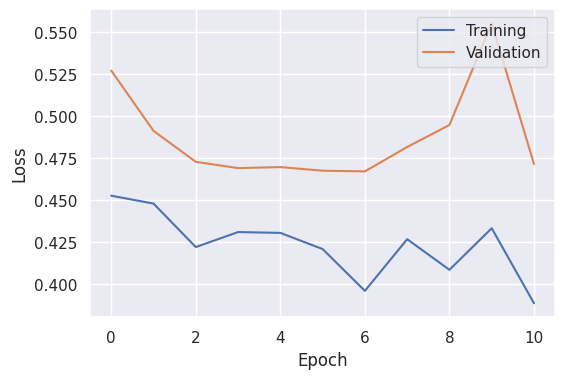

In [20]:
def batch_normalize_xy(X, Y):
    sample_mean = tf.constant([[X_mean]])
    sample_std = tf.constant([[X_std]])
    X = (X - sample_mean) / sample_std
    X = tf.where(tf.math.is_nan(X), tf.zeros_like(X), X)

    y_mean = tf.constant(Y_mean)
    y_std = tf.constant(Y_std)
    Y = (Y - y_mean) / y_std
    # Y = tf.where(tf.math.is_nan(Y), tf.ones_like(Y) * 63, Y)
    # indices = tf.constant(list(range(0,7)) + list(range(11,18)))
    # Y = tf.gather(Y, indices)
    return X, Y


ds1 = (
    train_dataset.repeat()
    .shuffle(80000)
    .batch(
        BATCH_SIZE,
    )
    .map(batch_normalize_xy, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
ds2 = (
    eval_dataset.batch(
        BATCH_SIZE_TEST,
    )
    .map(batch_normalize_xy, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

fname = f"{outname}_densenet_l1_ckpt"
dn_structure = (12,)
epochs = 100

# tf.debugging.set_log_device_placement(True)
# strategy = tf.distribute.MirroredStrategy()
# print("Number of devices: {}".format(strategy.num_replicas_in_sync))

m = densenet_model(dn_structure, width, nbands, 1)
print(m.summary())

m.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    # loss=tf.keras.losses.get("MeanSquaredError"),
    loss=tf.keras.losses.get("MeanAbsoluteError"),
    metrics=[tf.keras.metrics.get(metric) for metric in ["RootMeanSquaredError"]],
)

# with strategy.scope():
if os.path.exists(fname):
    m.load_weights(fname)
    print("Pretrained model loaded...")
else:
    print("Building new model...")

earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    verbose=1,
    patience=5,
    restore_best_weights=True,
)

history = m.fit(
    x=ds1,
    epochs=epochs,
    callbacks=[
        earlystop_callback,
    ],
    steps_per_epoch=int(n_train / BATCH_SIZE),
    validation_data=ds2,
)
m.save_weights(fname, save_format="h5")

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(f"{fname}_history.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# define evaluation function
def eval_plot(
    ds_test,
    model,
    out_name,
    n_samples=None,
):
    ds2 = (
        ds_test.batch(BATCH_SIZE_TEST)
        .map(batch_normalize_xy, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    X_list = []
    y_list = []
    for X, Y in ds2:
        X_list.append(X.numpy())
        y_list.append(Y.numpy())
    X_test = np.concatenate(X_list)
    y_test = np.concatenate(y_list)

    if n_samples is not None:
        idx_test = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
        X_test = X_test[idx_test, :]
        y_test = y_test[idx_test, None]
    y_test = y_test * np.array(Y_std)[None, :] + np.array(Y_mean)[None, :]
    predictions = (
        model.predict(X_test, verbose=1) * np.array(Y_std)[None, :]
        + np.array(Y_mean)[None, :]
    )

    Parallel(n_jobs=-1)(
        delayed(density_scatter_plot)(
            y_test[:, i_test][~np.isnan(y_test[:, i_test])],
            predictions[:, i_test][~np.isnan(y_test[:, i_test])],
            file_name=f"{out_name}_xyscatter.png",
        )
        for i_test in tqdm(range(y_test.shape[1]))
    )
    Parallel(n_jobs=-1)(
        delayed(residual_box_plot)(
            y_test[:, i_test][~np.isnan(y_test[:, i_test])],
            predictions[:, i_test][~np.isnan(y_test[:, i_test])],
            outname=f"{out_name}_residual.png",
            floating=True,
        )
        for i_test in tqdm(range(y_test.shape[1]))
    )
    Parallel(n_jobs=-1)(
        delayed(residual2_box_plot)(
            y_test[:, i_test][~np.isnan(y_test[:, i_test])],
            predictions[:, i_test][~np.isnan(y_test[:, i_test])],
            outname=f"{out_name}_residual2.png",
            floating=True,
        )
        for i_test in tqdm(range(y_test.shape[1]))
    )

63/63 [==============================] - 1s 8ms/step


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
2024-10-19 12:08:37.369907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ray/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/ray/anaconda3/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
100%|██████████| 1/1 [00:00<00:00, 1076.57it/s]
2024-10-19 12:08:41.920360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could

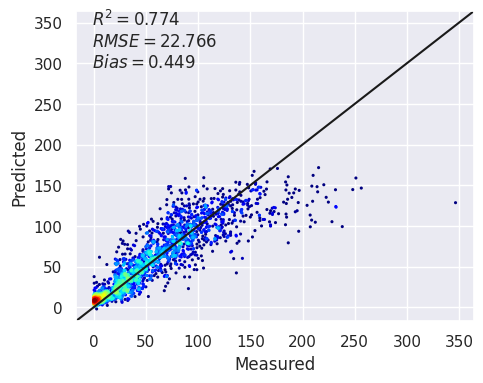

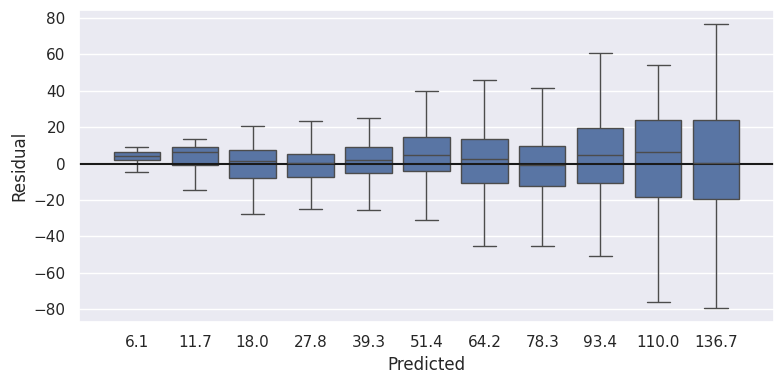

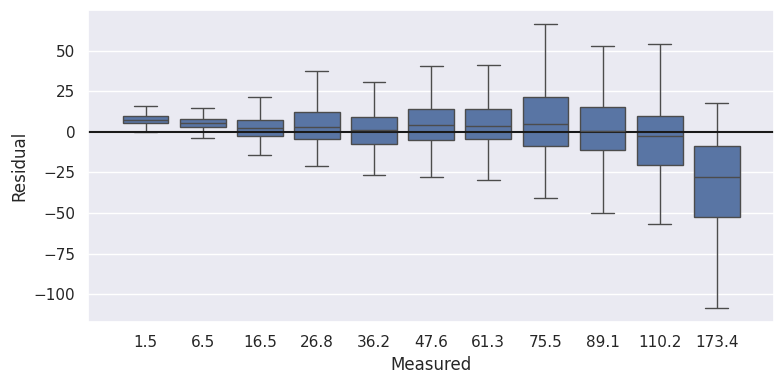

In [22]:
eval_plot(
    train_dataset,
    m,
    f"{fname}_train",
    n_samples=2000,
)

19/19 [==============================] - 0s 8ms/step


100%|██████████| 1/1 [00:00<00:00, 1325.21it/s]
2024-10-19 12:09:16.424244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ray/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 12.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/ray/anaconda3/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
100%|██████████| 1/1 [00:00<00:00, 1359.14it/s]
2024-10-19 12:09:20.789113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cou

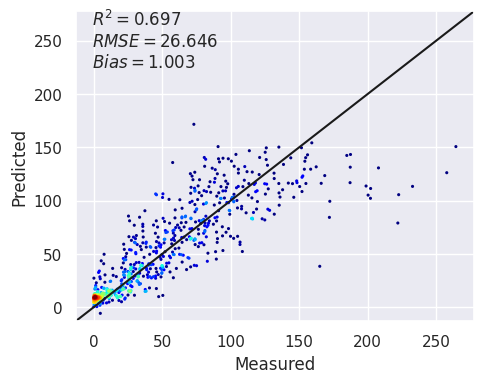

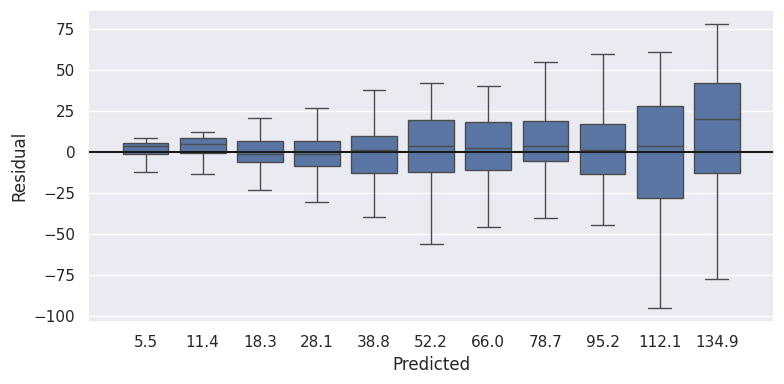

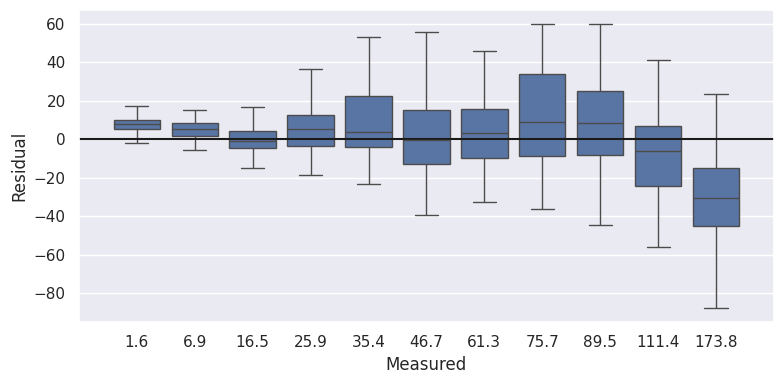

In [26]:
eval_plot(
    eval_dataset,
    m,
    f"{fname}_eval",
    n_samples=600,
)

In [19]:
width = 7
bands = list(range(12))
chunk_size = 800
mask_band = 4

dn_structure = (12,)
fname = f"{outname}_densenet_l1_ckpt.h5"


m = densenet_model(dn_structure, width, nbands, 1)
m.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.get("MeanAbsoluteError"),
    metrics=[tf.keras.metrics.get(metric) for metric in ["RootMeanSquaredError"]],
)

m.load_weights(fname)

In [20]:
def build_vrt_mosaic(in_file, out_file):
    in_fname = "merge_list.txt"
    with open(in_fname, "w") as f:
        f.writelines("%s\n" % i for i in in_file)
    command = f"gdalbuildvrt -overwrite -input_file_list {in_fname} {out_file}"
    print(command)
    output = os.system(command)
    print(output)


def yprep_model(Y):
    y_mean = np.array(Y_mean)
    y_std = np.array(Y_std)
    Y = Y * y_std[None, :] + y_mean[None, :]
    return Y


def xprep_model(X):
    sample_mean = np.array(X_mean)
    sample_std = np.array(X_std)
    X = (X - sample_mean[None, :]) / sample_std[None, :]
    X = np.where(np.isnan(X), np.zeros_like(X), X)
    X = X[:, :]
    return X

In [21]:
os.makedirs(f"{outname}_densenet_l1", exist_ok=True)
out_prefix = f"{outname}_densenet_l1/pred"

ij_lst = [
    (i, j)
    for i in range(np.ceil(da1.shape[1] / chunk_size).astype(int))
    for j in range(np.ceil(da1.shape[2] / chunk_size).astype(int))
]
random.shuffle(ij_lst)

# Parallel(n_jobs=2)(
Parallel(n_jobs=1, prefer="threads")(
    delayed(data_cnn_prediction)(
        ij,
        chunk_size,
        path_tif,
        m,
        yprep_model,
        xprep_model,
        bands=bands,
        mask_band=mask_band,
        nbands_out=1,
        patchsize=(width, width),
        strides=(1, 1),
        scale=10,
        crs="EPSG:4326",
        withxy=False,
        out_name=out_prefix,
    )
    for ij in tqdm(ij_lst)
)

  0%|          | 0/14415 [00:00<?, ?it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_68_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_132.tif
(1, 807, 807, 12)


  0%|          | 9/14415 [00:01<49:56,  4.81it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_86_28.tif
(1, 807, 807, 12)


/tmp/ipykernel_14634/3963683614.py:21: RuntimeWarning: invalid value encountered in divide
  X = (X - sample_mean[None, :]) / sample_std[None, :]
2024-10-21 12:13:39.949930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906


  43/5013 [..............................] - ETA: 12s   

2024-10-21 12:13:40.322978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5013/5013 [==============================] - 14s 2ms/step


  0%|          | 11/14415 [00:28<13:34:24,  3.39s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 12/14415 [00:53<26:12:57,  6.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_80_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_58.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 15/14415 [01:18<29:05:23,  7.27s/it]

(1, 807, 807, 12)


  0%|          | 16/14415 [01:20<25:40:19,  6.42s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  0%|          | 17/14415 [01:45<39:15:32,  9.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_13.tif
(1, 807, 807, 12)
3198/3198 [==============================] - 9s 2ms/step


  0%|          | 19/14415 [02:02<37:35:56,  9.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_76.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  0%|          | 31/14415 [02:28<15:54:40,  3.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_109.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  0%|          | 33/14415 [02:53<21:04:19,  5.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_116.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 37/14415 [03:18<22:03:27,  5.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_92_62.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 40/14415 [03:43<24:10:06,  6.05s/it]

(1, 807, 27, 12)
test/mexico_agb/agb_30m_densenet_l1/pred_9_33.tif
(1, 807, 807, 12)


  0%|          | 42/14415 [03:45<19:06:35,  4.79s/it]

(1, 807, 807, 12)


  0%|          | 43/14415 [03:46<17:15:25,  4.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_20.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 47/14415 [04:11<20:42:41,  5.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_63_37.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 49/14415 [04:36<27:47:34,  6.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_90.tif
(1, 807, 807, 12)


  0%|          | 54/14415 [04:38<15:25:38,  3.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_20_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_104.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  0%|          | 59/14415 [05:03<17:12:35,  4.32s/it]

(1, 807, 807, 12)


  0%|          | 60/14415 [05:05<16:12:12,  4.06s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_152.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 64/14415 [05:29<19:13:04,  4.82s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 65/14415 [05:54<28:36:45,  7.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_149.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  0%|          | 68/14415 [06:19<30:10:45,  7.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_121.tif
(1, 807, 807, 12)


  1%|          | 73/14415 [06:21<17:27:04,  4.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_81.tif
(1, 807, 807, 12)


  1%|          | 75/14415 [06:23<14:39:39,  3.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_117.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|          | 77/14415 [06:48<22:26:29,  5.63s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|          | 78/14415 [07:13<33:03:38,  8.30s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 79/14415 [07:38<44:02:22, 11.06s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_34_8.tif
(1, 807, 807, 12)


  1%|          | 81/14415 [07:40<31:13:51,  7.84s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_36_81.tif
(1, 807, 807, 12)


  1%|          | 83/14415 [07:41<22:31:51,  5.66s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_86.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 88/14415 [08:06<21:01:36,  5.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_143.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 93/14415 [08:31<20:29:58,  5.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_26.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 100/14415 [08:56<17:31:59,  4.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_76_149.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 102/14415 [09:21<22:43:12,  5.71s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_113.tif
(1, 807, 807, 12)


  1%|          | 106/14415 [09:23<16:10:14,  4.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_152.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 108/14415 [09:48<22:12:13,  5.59s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_51.tif
(1, 807, 807, 12)


  1%|          | 113/14415 [09:49<13:58:45,  3.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_29.tif
(1, 807, 807, 12)


  1%|          | 128/14415 [09:51<5:28:23,  1.38s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_42_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_89.tif
(1, 807, 807, 12)


  1%|          | 132/14415 [09:53<4:45:48,  1.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_150.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 135/14415 [10:18<9:33:15,  2.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_45.tif
(1, 618, 807, 12)


  1%|          | 141/14415 [10:19<6:42:43,  1.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_4.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 143/14415 [10:44<12:24:06,  3.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_34.tif
(1, 807, 807, 12)


  1%|          | 146/14415 [10:45<10:10:30,  2.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_15.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 149/14415 [11:10<15:34:56,  3.93s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_6_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_15.tif
(1, 807, 807, 12)


  1%|          | 153/14415 [11:12<11:12:52,  2.83s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 154/14415 [11:36<19:58:18,  5.04s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 155/14415 [12:01<29:50:16,  7.53s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 156/14415 [12:26<40:11:51, 10.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_55.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 160/14415 [12:50<32:48:35,  8.29s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_48_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_124.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 168/14415 [13:15<21:05:41,  5.33s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_36_98.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 170/14415 [13:40<25:49:51,  6.53s/it]

(1, 807, 807, 12)


  1%|          | 171/14415 [13:42<23:52:35,  6.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_9.tif
(1, 807, 807, 12)


  1%|          | 175/14415 [13:44<15:27:38,  3.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_92.tif
(1, 807, 807, 12)


  1%|          | 177/14415 [13:46<12:51:43,  3.25s/it]

(1, 807, 807, 12)


  1%|          | 178/14415 [13:47<11:59:10,  3.03s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|          | 179/14415 [14:12<25:48:25,  6.53s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|          | 180/14415 [14:37<39:10:12,  9.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_72_142.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|▏         | 182/14415 [15:02<42:30:42, 10.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_84_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_114.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|▏         | 185/14415 [15:26<38:18:10,  9.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_48_113.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|▏         | 187/14415 [15:51<41:31:27, 10.51s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_55.tif
(1, 807, 807, 12)
4247/4247 [==============================] - 11s 2ms/step


  1%|▏         | 198/14415 [16:13<18:12:26,  4.61s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|▏         | 199/14415 [16:39<24:55:37,  6.31s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|▏         | 200/14415 [17:04<32:41:33,  8.28s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|▏         | 201/14415 [17:29<41:38:07, 10.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_15.tif
(1, 807, 807, 12)


  1%|▏         | 203/14415 [17:31<31:16:00,  7.92s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|▏         | 204/14415 [17:56<42:10:37, 10.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_130.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  1%|▏         | 206/14415 [18:21<44:26:43, 11.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_68.tif
(1, 807, 804, 12)


  1%|▏         | 210/14415 [18:23<24:06:33,  6.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_83.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|▏         | 212/14415 [18:47<30:21:51,  7.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_36.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  1%|▏         | 214/14415 [19:12<35:16:19,  8.94s/it]

(1, 807, 807, 12)


  1%|▏         | 215/14415 [19:14<30:46:59,  7.80s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_6_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_78.tif
(1, 618, 807, 12)


  2%|▏         | 218/14415 [19:15<18:59:40,  4.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_67_38.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 220/14415 [19:40<27:16:05,  6.92s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_104.tif
(1, 807, 807, 12)
4537/4537 [==============================] - 12s 2ms/step


  2%|▏         | 222/14415 [20:03<32:38:35,  8.28s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 223/14415 [20:28<43:49:53, 11.12s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_146.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_45.tif
(1, 807, 807, 12)


  2%|▏         | 227/14415 [20:30<23:05:34,  5.86s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 228/14415 [20:54<33:55:48,  8.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_62.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_39.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 231/14415 [21:19<33:24:30,  8.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_6_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_94.tif
(1, 807, 807, 12)


  2%|▏         | 235/14415 [21:21<19:52:42,  5.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_81_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_146.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_77.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 245/14415 [21:46<13:52:13,  3.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_38.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 247/14415 [22:11<19:03:41,  4.84s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_2.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 253/14415 [22:37<18:09:43,  4.62s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_95.tif
(1, 807, 807, 12)


  2%|▏         | 258/14415 [22:38<12:51:41,  3.27s/it]

(1, 807, 807, 12)


  2%|▏         | 259/14415 [22:40<12:21:10,  3.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_75.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 274/14415 [23:05<8:36:06,  2.19s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_21_83.tif
(1, 807, 807, 12)
2848/2848 [==============================] - 8s 2ms/step


  2%|▏         | 276/14415 [23:20<10:57:50,  2.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_8.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 282/14415 [23:46<12:44:29,  3.25s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_34.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 287/14415 [24:11<14:37:08,  3.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_53.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 289/14415 [24:36<19:15:39,  4.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_62.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_94.tif
(1, 807, 807, 12)
46/46 [==============================] - 0s 3ms/step


  2%|▏         | 293/14415 [24:38<14:26:01,  3.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_56.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 295/14415 [25:02<20:06:15,  5.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_37.tif
(1, 807, 807, 12)


  2%|▏         | 300/14415 [25:04<13:07:02,  3.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_112.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 304/14415 [25:29<16:26:19,  4.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_2_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_60.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 307/14415 [25:54<20:21:59,  5.20s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 308/14415 [26:19<28:22:56,  7.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_84.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 310/14415 [26:44<32:58:21,  8.42s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 311/14415 [27:09<42:04:09, 10.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_36_83.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 313/14415 [27:34<44:12:31, 11.29s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 314/14415 [27:59<53:21:51, 13.62s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_0.tif
(1, 807, 807, 12)


  2%|▏         | 316/14415 [28:01<37:04:02,  9.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_153.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 318/14415 [28:25<40:32:01, 10.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_99.tif
(1, 807, 807, 12)


  2%|▏         | 320/14415 [28:27<28:55:18,  7.39s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_63.tif
(1, 807, 807, 12)


  2%|▏         | 323/14415 [28:29<18:12:07,  4.65s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_4.tif
(1, 807, 807, 12)


  2%|▏         | 326/14415 [28:30<12:19:45,  3.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_72_127.tif
(1, 807, 807, 12)


  2%|▏         | 328/14415 [28:32<10:03:06,  2.57s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 329/14415 [28:57<23:34:03,  6.02s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_71.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 331/14415 [29:22<31:10:59,  7.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_78.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 333/14415 [29:47<36:37:08,  9.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_38.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 335/14415 [30:12<40:22:54, 10.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_129.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  2%|▏         | 338/14415 [30:37<37:13:52,  9.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_46_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_94.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 343/14415 [31:02<28:44:34,  7.35s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 344/14415 [31:27<37:08:18,  9.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_107.tif
(1, 807, 807, 12)


  2%|▏         | 349/14415 [31:29<20:31:03,  5.25s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_32_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_145.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 353/14415 [31:53<21:50:19,  5.59s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 354/14415 [32:18<30:10:20,  7.72s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 355/14415 [32:43<39:18:44, 10.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_22.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  2%|▏         | 359/14415 [33:08<32:45:00,  8.39s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_64_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_39.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 362/14415 [33:33<32:38:01,  8.36s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 363/14415 [33:58<41:07:18, 10.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_46.tif
(1, 807, 807, 12)


  3%|▎         | 365/14415 [34:00<30:51:51,  7.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_92_21.tif
(1, 807, 807, 12)
4759/4759 [==============================] - 13s 2ms/step


  3%|▎         | 367/14415 [34:24<35:32:36,  9.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_137.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 376/14415 [34:49<19:30:40,  5.00s/it]

(1, 807, 807, 12)


  3%|▎         | 377/14415 [34:51<18:21:46,  4.71s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_75.tif
(1, 807, 807, 12)


  3%|▎         | 381/14415 [34:52<12:33:52,  3.22s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_61.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 386/14415 [35:17<15:14:15,  3.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_44_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_119.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 390/14415 [35:42<17:56:59,  4.61s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 391/14415 [36:07<25:45:27,  6.61s/it]

(1, 807, 807, 12)


  3%|▎         | 392/14415 [36:09<23:29:08,  6.03s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 393/14415 [36:34<34:24:52,  8.84s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_65_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_87.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 396/14415 [36:59<33:28:44,  8.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_140.tif
(1, 807, 807, 12)


  3%|▎         | 401/14415 [37:00<18:01:07,  4.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_19.tif
(1, 807, 807, 12)


  3%|▎         | 408/14415 [37:02<9:38:31,  2.48s/it] 

(1, 807, 807, 12)


  3%|▎         | 409/14415 [37:04<9:23:21,  2.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_47.tif
(1, 807, 807, 12)


  3%|▎         | 411/14415 [37:06<8:07:26,  2.09s/it]

(1, 807, 807, 12)


  3%|▎         | 412/14415 [37:07<7:58:27,  2.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_43_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_140.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 415/14415 [37:32<16:33:36,  4.26s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 416/14415 [37:57<28:08:44,  7.24s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 417/14415 [38:22<40:02:38, 10.30s/it]

(1, 807, 807, 12)


  3%|▎         | 418/14415 [38:24<33:28:27,  8.61s/it]

(1, 807, 807, 12)
1580/1580 [==============================] - 4s 2ms/step


  3%|▎         | 419/14415 [38:33<33:58:06,  8.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_115.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 426/14415 [38:58<20:07:12,  5.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_0.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 428/14415 [39:23<26:17:52,  6.77s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 429/14415 [39:48<35:50:48,  9.23s/it]

(1, 807, 807, 12)


  3%|▎         | 430/14415 [39:50<31:08:15,  8.02s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_87.tif
(1, 807, 807, 12)


  3%|▎         | 433/14415 [39:51<19:18:49,  4.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_26_100.tif
(1, 807, 807, 12)


  3%|▎         | 435/14415 [39:53<14:48:10,  3.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_133.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  3%|▎         | 442/14415 [40:18<14:16:19,  3.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_149.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 444/14415 [40:43<20:52:33,  5.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_40_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_5.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 450/14415 [41:08<18:36:15,  4.80s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_7.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 452/14415 [41:32<23:48:51,  6.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_23.tif
(1, 807, 807, 12)


  3%|▎         | 459/14415 [41:34<13:05:36,  3.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_40_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_59.tif
(1, 807, 807, 12)


  3%|▎         | 468/14415 [41:36<7:21:47,  1.90s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_12_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_89.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 474/14415 [42:01<9:58:42,  2.58s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  3%|▎         | 475/14415 [42:26<15:52:15,  4.10s/it]

(1, 807, 807, 12)


  3%|▎         | 476/14415 [42:27<15:03:38,  3.89s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  3%|▎         | 477/14415 [42:52<24:13:14,  6.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_11.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 479/14415 [43:17<29:57:13,  7.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_86_102.tif
(1, 807, 807, 12)


  3%|▎         | 481/14415 [43:19<23:06:55,  5.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_67_80.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 483/14415 [43:44<29:52:45,  7.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_46_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_32.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  3%|▎         | 486/14415 [44:09<30:43:25,  7.94s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  3%|▎         | 487/14415 [44:34<40:41:19, 10.52s/it]

(1, 807, 807, 12)


  3%|▎         | 488/14415 [44:36<34:49:50,  9.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_123.tif
(1, 807, 807, 12)
1620/1620 [==============================] - 4s 2ms/step


  3%|▎         | 497/14415 [44:45<13:32:58,  3.50s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  3%|▎         | 498/14415 [45:10<21:41:32,  5.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_61_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_136.tif
(1, 807, 807, 12)


  3%|▎         | 502/14415 [45:12<14:27:13,  3.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_20_62.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_8.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▎         | 505/14415 [45:36<19:14:09,  4.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_26.tif
(1, 807, 807, 12)


  4%|▎         | 508/14415 [45:38<14:26:39,  3.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_113.tif
(1, 807, 807, 12)


  4%|▎         | 518/14415 [45:40<6:30:55,  1.69s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_68_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_134.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_63.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▎         | 524/14415 [46:05<9:39:51,  2.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_2_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_36.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▎         | 528/14415 [46:30<13:02:12,  3.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_61_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_30.tif
(1, 807, 807, 12)


  4%|▎         | 532/14415 [46:31<10:09:24,  2.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_152.tif
(1, 807, 807, 12)


  4%|▎         | 535/14415 [46:33<8:26:30,  2.19s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_39_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_146.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_22.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▍         | 541/14415 [46:58<11:15:12,  2.92s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_86_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_77.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 548/14415 [47:23<12:15:00,  3.18s/it]

(1, 807, 807, 12)


  4%|▍         | 549/14415 [47:25<11:52:58,  3.09s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 550/14415 [47:49<19:44:47,  5.13s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 551/14415 [48:14<28:52:20,  7.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_46.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▍         | 553/14415 [48:39<33:41:07,  8.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_131.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▍         | 560/14415 [49:04<22:34:15,  5.86s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 561/14415 [49:29<30:06:20,  7.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_93.tif
(1, 807, 27, 12)


/tmp/ipykernel_14634/3963683614.py:21: RuntimeWarning: divide by zero encountered in divide
  X = (X - sample_mean[None, :]) / sample_std[None, :]


132/132 [==============================] - 0s 2ms/step


/home/ray/default_cld_kxc747wnizlp9aa3xtzhdstcmk/a2105_global100/ml_functions.py:1151: RuntimeWarning: invalid value encountered in cast
  model_y_pred = (model_y_pred * scale).astype(np.int16)
  4%|▍         | 570/14415 [49:31<13:15:20,  3.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_69.tif
(1, 807, 807, 12)


  4%|▍         | 573/14415 [49:32<10:55:50,  2.84s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_154.tif
(1, 807, 807, 12)


  4%|▍         | 575/14415 [49:34<9:41:14,  2.52s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_45_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_24.tif
(1, 807, 807, 12)


  4%|▍         | 581/14415 [49:36<6:08:01,  1.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_136.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 585/14415 [50:01<11:13:13,  2.92s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_19.tif
(1, 807, 807, 12)


  4%|▍         | 589/14415 [50:03<8:27:29,  2.20s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_51_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_134.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_7.tif
(1, 807, 807, 12)


  4%|▍         | 596/14415 [50:05<5:17:39,  1.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_14.tif
(1, 807, 807, 12)


  4%|▍         | 603/14415 [50:06<3:39:17,  1.05it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_26_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_146.tif
(1, 807, 807, 12)


  4%|▍         | 609/14415 [50:08<2:52:08,  1.34it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_87_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_105.tif
(1, 807, 807, 12)


  4%|▍         | 616/14415 [50:10<2:11:32,  1.75it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_82_48.tif
(1, 807, 807, 12)


  4%|▍         | 618/14415 [50:11<2:18:17,  1.66it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_9_104.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 620/14415 [50:36<9:08:43,  2.39s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_87.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 622/14415 [51:02<16:03:14,  4.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_83.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 626/14415 [51:27<18:52:13,  4.93s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_34_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_24.tif
(1, 807, 807, 12)


  4%|▍         | 629/14415 [51:29<14:30:23,  3.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 636/14415 [51:54<14:05:31,  3.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_41.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 638/14415 [52:19<19:31:58,  5.10s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 639/14415 [52:44<27:20:14,  7.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_134.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▍         | 641/14415 [53:09<31:54:16,  8.34s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  4%|▍         | 642/14415 [53:34<40:37:57, 10.62s/it]

(1, 807, 807, 12)


  4%|▍         | 643/14415 [53:35<34:58:54,  9.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_84.tif
(1, 807, 807, 12)


  4%|▍         | 647/14415 [53:37<18:48:52,  4.92s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  4%|▍         | 648/14415 [54:02<30:05:12,  7.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_121.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▍         | 655/14415 [54:27<20:08:21,  5.27s/it]

(1, 807, 807, 12)


  5%|▍         | 656/14415 [54:28<18:42:17,  4.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_5.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▍         | 658/14415 [54:53<25:30:57,  6.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_6_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_7.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▍         | 663/14415 [55:18<22:31:15,  5.90s/it]

(1, 807, 807, 12)


  5%|▍         | 664/14415 [55:20<20:41:27,  5.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_41.tif
(1, 807, 807, 12)
2241/2241 [==============================] - 6s 2ms/step


  5%|▍         | 668/14415 [55:32<17:10:15,  4.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_65_72.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▍         | 670/14415 [55:57<23:50:07,  6.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_42.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▍         | 680/14415 [56:22<15:05:53,  3.96s/it]

(1, 807, 807, 12)


  5%|▍         | 681/14415 [56:24<14:25:48,  3.78s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▍         | 682/14415 [56:49<22:50:53,  5.99s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▍         | 683/14415 [57:14<32:04:49,  8.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_145.tif
(1, 807, 807, 12)


  5%|▍         | 692/14415 [57:16<12:33:49,  3.30s/it]

(1, 807, 807, 12)


  5%|▍         | 693/14415 [57:18<12:02:03,  3.16s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_47_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_111.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▍         | 698/14415 [57:43<14:56:23,  3.92s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_20.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▍         | 701/14415 [58:08<19:07:52,  5.02s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_66.tif
(1, 807, 807, 12)


  5%|▍         | 703/14415 [58:10<16:05:45,  4.23s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_151.tif
(1, 807, 807, 12)


  5%|▍         | 706/14415 [58:12<12:00:05,  3.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_111.tif
(1, 807, 807, 12)


  5%|▍         | 713/14415 [58:13<6:34:11,  1.73s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_71_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_111.tif
(1, 807, 807, 12)


  5%|▍         | 717/14415 [58:15<5:10:29,  1.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_46.tif
(1, 807, 807, 12)


  5%|▍         | 719/14415 [58:17<4:55:30,  1.29s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▍         | 720/14415 [58:42<14:32:22,  3.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_75.tif
(1, 807, 807, 12)


  5%|▌         | 725/14415 [58:43<8:46:21,  2.31s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_39_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_67.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▌         | 728/14415 [59:08<14:52:22,  3.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_62.tif
(1, 807, 807, 12)


  5%|▌         | 737/14415 [59:10<7:18:48,  1.92s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_77_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_105.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▌         | 741/14415 [59:35<11:34:12,  3.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_50_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_11.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▌         | 746/14415 [1:00:00<13:51:58,  3.65s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_59.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▌         | 752/14415 [1:00:26<14:37:38,  3.85s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▌         | 753/14415 [1:00:51<20:48:49,  5.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_84_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_34.tif
(1, 807, 807, 12)


  5%|▌         | 756/14415 [1:00:53<16:14:34,  4.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_120.tif
(1, 807, 807, 12)


  5%|▌         | 759/14415 [1:00:54<12:34:12,  3.31s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_130.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▌         | 762/14415 [1:01:20<17:47:03,  4.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_133.tif
(1, 807, 807, 12)


  5%|▌         | 767/14415 [1:01:21<11:19:44,  2.99s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_20.tif
(1, 807, 807, 12)


  5%|▌         | 769/14415 [1:01:23<9:50:38,  2.60s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_69_9.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▌         | 771/14415 [1:01:48<17:29:07,  4.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_103.tif
(1, 807, 807, 12)


  5%|▌         | 776/14415 [1:01:49<10:36:43,  2.80s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▌         | 777/14415 [1:02:14<19:39:55,  5.19s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▌         | 778/14415 [1:02:39<29:44:31,  7.85s/it]

(1, 807, 807, 12)


  5%|▌         | 779/14415 [1:02:41<26:03:00,  6.88s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▌         | 780/14415 [1:03:06<38:47:51, 10.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_27.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▌         | 782/14415 [1:03:31<41:30:56, 10.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_95.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  5%|▌         | 786/14415 [1:03:56<32:34:33,  8.60s/it]

(1, 807, 807, 12)


  5%|▌         | 787/14415 [1:03:57<28:45:25,  7.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_145.tif
(1, 807, 807, 12)


  5%|▌         | 791/14415 [1:03:59<16:09:30,  4.27s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  5%|▌         | 792/14415 [1:04:24<27:14:09,  7.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_125.tif
(1, 807, 807, 12)


  6%|▌         | 794/14415 [1:04:26<20:18:28,  5.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_112.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 801/14415 [1:04:51<16:16:47,  4.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_26_94.tif
(1, 807, 807, 12)


  6%|▌         | 803/14415 [1:04:53<13:51:54,  3.67s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 804/14415 [1:05:17<23:26:14,  6.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_7.tif
(1, 807, 807, 12)


  6%|▌         | 806/14415 [1:05:19<18:19:01,  4.85s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_93.tif
(1, 807, 807, 12)
4537/4537 [==============================] - 12s 2ms/step


  6%|▌         | 811/14415 [1:05:41<17:36:52,  4.66s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 812/14415 [1:06:06<26:53:47,  7.12s/it]

(1, 807, 807, 12)


  6%|▌         | 813/14415 [1:06:08<23:58:56,  6.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_63.tif
(1, 807, 807, 12)


  6%|▌         | 823/14415 [1:06:10<8:11:36,  2.17s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_56_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_28.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 827/14415 [1:06:35<12:26:38,  3.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_147.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 830/14415 [1:07:00<16:46:43,  4.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_40.tif
(1, 807, 807, 12)


  6%|▌         | 836/14415 [1:07:02<10:37:32,  2.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_13.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 839/14415 [1:07:27<15:13:07,  4.04s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 840/14415 [1:07:52<22:46:32,  6.04s/it]

(1, 807, 807, 12)


  6%|▌         | 841/14415 [1:07:54<20:48:30,  5.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_94.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 843/14415 [1:08:18<27:22:36,  7.26s/it]

(1, 807, 807, 12)


  6%|▌         | 844/14415 [1:08:20<24:12:00,  6.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_91.tif
(1, 807, 807, 12)
3230/3230 [==============================] - 9s 2ms/step


  6%|▌         | 849/14415 [1:08:37<18:11:16,  4.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_47_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_90.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 854/14415 [1:09:03<18:40:32,  4.96s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 855/14415 [1:09:29<27:14:25,  7.23s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_8.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 857/14415 [1:09:53<31:50:43,  8.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_15.tif
(1, 807, 807, 12)


  6%|▌         | 859/14415 [1:09:55<24:38:25,  6.54s/it]

(1, 807, 807, 12)
2644/2644 [==============================] - 7s 2ms/step


  6%|▌         | 860/14415 [1:10:10<29:09:54,  7.75s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 861/14415 [1:10:35<41:20:58, 10.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_121.tif
(1, 807, 807, 12)


  6%|▌         | 865/14415 [1:10:37<21:15:39,  5.65s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▌         | 866/14415 [1:11:02<32:18:48,  8.59s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_109.tif
(1, 807, 807, 12)


  6%|▌         | 869/14415 [1:11:04<20:21:31,  5.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_71.tif
(1, 807, 807, 12)


  6%|▌         | 871/14415 [1:11:05<15:39:38,  4.16s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_134.tif
(1, 807, 807, 12)


  6%|▌         | 873/14415 [1:11:07<12:07:55,  3.23s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 874/14415 [1:11:32<25:54:28,  6.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_153.tif
(1, 807, 807, 12)


  6%|▌         | 879/14415 [1:11:34<12:31:51,  3.33s/it]

(1, 807, 807, 12)


  6%|▌         | 880/14415 [1:11:36<11:48:16,  3.14s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 881/14415 [1:12:01<25:03:58,  6.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_99.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 886/14415 [1:12:26<21:49:48,  5.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_92.tif
(1, 807, 807, 12)


  6%|▌         | 891/14415 [1:12:28<12:58:11,  3.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_82.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▌         | 898/14415 [1:12:53<13:11:39,  3.51s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_78.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▋         | 904/14415 [1:13:18<14:08:16,  3.77s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_92_17.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▋         | 906/14415 [1:13:43<18:56:08,  5.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_64_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_79.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▋         | 909/14415 [1:14:08<21:50:37,  5.82s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▋         | 910/14415 [1:14:33<29:14:17,  7.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_10.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  6%|▋         | 913/14415 [1:14:58<29:53:53,  7.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_23.tif
(1, 807, 807, 12)


  6%|▋         | 916/14415 [1:15:00<21:31:31,  5.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_86_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_8.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▋         | 919/14415 [1:15:25<24:21:12,  6.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_105.tif
(1, 807, 807, 12)


  6%|▋         | 923/14415 [1:15:27<16:04:18,  4.29s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_30.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▋         | 926/14415 [1:15:51<20:12:19,  5.39s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  6%|▋         | 927/14415 [1:16:16<28:51:51,  7.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_4.tif
(1, 807, 807, 12)


  7%|▋         | 943/14415 [1:16:18<8:04:48,  2.16s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 944/14415 [1:16:43<13:15:59,  3.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_38.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 946/14415 [1:17:08<18:10:28,  4.86s/it]

(1, 807, 807, 12)


  7%|▋         | 947/14415 [1:17:09<17:06:17,  4.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_15.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 953/14415 [1:17:34<16:21:07,  4.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_131.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 955/14415 [1:17:59<21:34:11,  5.77s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_36_28.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 957/14415 [1:18:24<26:48:34,  7.17s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_141.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 14s 2ms/step


  7%|▋         | 962/14415 [1:18:50<23:41:05,  6.34s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_2.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 964/14415 [1:19:15<28:00:36,  7.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_115.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 966/14415 [1:19:40<32:03:43,  8.58s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_37.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 968/14415 [1:20:05<35:41:05,  9.55s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 969/14415 [1:20:31<44:11:24, 11.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_60.tif
(1, 807, 807, 12)


  7%|▋         | 974/14415 [1:20:32<22:27:18,  6.01s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 975/14415 [1:20:58<31:31:24,  8.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_140.tif
(1, 807, 807, 12)


  7%|▋         | 977/14415 [1:20:59<24:02:17,  6.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_40_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_85.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 982/14415 [1:21:25<21:29:33,  5.76s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_62.tif
(1, 807, 807, 12)


  7%|▋         | 984/14415 [1:21:26<17:31:48,  4.70s/it]

(1, 807, 807, 12)


  7%|▋         | 985/14415 [1:21:28<16:03:17,  4.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_43.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 989/14415 [1:21:53<19:10:32,  5.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_54.tif
(1, 807, 807, 12)
4317/4317 [==============================] - 12s 2ms/step


  7%|▋         | 991/14415 [1:22:16<24:36:40,  6.60s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 992/14415 [1:22:41<34:30:31,  9.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_31.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 994/14415 [1:23:06<38:01:06, 10.20s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 995/14415 [1:23:31<47:30:25, 12.74s/it]

(1, 807, 807, 12)


  7%|▋         | 996/14415 [1:23:32<39:27:24, 10.59s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_27_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_10.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 999/14415 [1:23:57<35:31:41,  9.53s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_14.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1002/14415 [1:24:22<33:43:17,  9.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_153.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1012/14415 [1:24:47<17:45:28,  4.77s/it]

(1, 807, 807, 12)


  7%|▋         | 1013/14415 [1:24:49<16:56:12,  4.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_20.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1015/14415 [1:25:14<22:41:13,  6.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_20.tif
(1, 807, 807, 12)


  7%|▋         | 1020/14415 [1:25:16<13:51:43,  3.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_124.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1025/14415 [1:25:41<15:38:10,  4.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_34_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_65.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 1028/14415 [1:26:06<19:15:03,  5.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_3_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_48.tif
(1, 807, 807, 12)


  7%|▋         | 1032/14415 [1:26:08<13:42:28,  3.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_118.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 1037/14415 [1:26:33<15:31:56,  4.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_27.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1042/14415 [1:26:58<16:38:33,  4.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_72_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_62.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_85.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1049/14415 [1:27:23<15:14:46,  4.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_117.tif
(1, 807, 807, 12)


  7%|▋         | 1054/14415 [1:27:25<11:10:36,  3.01s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_82.tif
(1, 807, 807, 12)


  7%|▋         | 1056/14415 [1:27:27<10:02:10,  2.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_151.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1062/14415 [1:27:52<12:08:19,  3.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_101.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 1065/14415 [1:28:17<16:12:42,  4.37s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  7%|▋         | 1066/14415 [1:28:42<23:12:34,  6.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_54.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1068/14415 [1:29:07<28:09:02,  7.59s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_77.tif
(1, 807, 807, 12)


  7%|▋         | 1070/14415 [1:29:09<22:26:06,  6.05s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1071/14415 [1:29:34<32:27:44,  8.76s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_50.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1073/14415 [1:29:59<36:21:46,  9.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_34.tif
(1, 618, 807, 12)
3830/3830 [==============================] - 10s 2ms/step


  7%|▋         | 1075/14415 [1:30:19<36:26:35,  9.83s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  7%|▋         | 1076/14415 [1:30:44<46:04:53, 12.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_67_52.tif
(1, 807, 807, 12)


  7%|▋         | 1078/14415 [1:30:46<32:03:43,  8.65s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_74.tif
(1, 807, 807, 12)


  7%|▋         | 1081/14415 [1:30:47<19:38:36,  5.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_105.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1087/14415 [1:31:12<17:21:32,  4.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_122.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1090/14415 [1:31:37<21:06:21,  5.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_27.tif
(1, 807, 807, 12)


  8%|▊         | 1097/14415 [1:31:39<11:23:32,  3.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_135.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 14s 2ms/step


  8%|▊         | 1099/14415 [1:32:04<17:07:00,  4.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_66.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1102/14415 [1:32:29<20:42:26,  5.60s/it]

(1, 807, 807, 12)
3180/3180 [==============================] - 9s 2ms/step


  8%|▊         | 1103/14415 [1:32:46<25:23:41,  6.87s/it]

(1, 807, 807, 12)


  8%|▊         | 1104/14415 [1:32:48<22:48:43,  6.17s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  8%|▊         | 1105/14415 [1:33:13<34:03:04,  9.21s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_134.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_36.tif
(1, 807, 807, 12)


  8%|▊         | 1111/14415 [1:33:15<14:52:51,  4.03s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1112/14415 [1:33:39<24:10:08,  6.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_26_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_97.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1121/14415 [1:34:05<15:42:51,  4.26s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1122/14415 [1:34:30<22:26:56,  6.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_35.tif
(1, 807, 807, 12)


  8%|▊         | 1127/14415 [1:34:31<14:15:28,  3.86s/it]

(1, 807, 807, 12)


  8%|▊         | 1128/14415 [1:34:33<13:27:23,  3.65s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1129/14415 [1:34:58<23:19:53,  6.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_1.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1131/14415 [1:35:23<29:28:04,  7.99s/it]

(1, 807, 807, 12)


  8%|▊         | 1132/14415 [1:35:25<25:49:53,  7.00s/it]

(1, 807, 807, 12)


  8%|▊         | 1133/14415 [1:35:27<22:11:35,  6.02s/it]

(1, 807, 807, 12)


  8%|▊         | 1134/14415 [1:35:29<18:52:30,  5.12s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1135/14415 [1:35:53<35:38:39,  9.66s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_89_127.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  8%|▊         | 1137/14415 [1:36:19<40:05:04, 10.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_63_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_85.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  8%|▊         | 1146/14415 [1:36:44<18:41:27,  5.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_47.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1149/14415 [1:37:09<21:45:54,  5.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_17.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1151/14415 [1:37:34<26:27:46,  7.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_63_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_4.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1157/14415 [1:37:59<21:28:49,  5.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_2_136.tif
(1, 807, 807, 12)


  8%|▊         | 1159/14415 [1:38:01<18:13:25,  4.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_43_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_23.tif
(1, 807, 807, 12)


  8%|▊         | 1166/14415 [1:38:03<10:03:04,  2.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_104.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1168/14415 [1:38:28<15:48:05,  4.29s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_64.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1170/14415 [1:38:52<21:22:50,  5.81s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1171/14415 [1:39:17<29:39:54,  8.06s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1172/14415 [1:39:42<38:37:01, 10.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_136.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1175/14415 [1:40:07<35:33:04,  9.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_32_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_100.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  8%|▊         | 1178/14415 [1:40:32<33:43:54,  9.17s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_136.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  8%|▊         | 1180/14415 [1:40:57<36:43:20,  9.99s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  8%|▊         | 1181/14415 [1:41:22<45:03:54, 12.26s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1182/14415 [1:41:47<53:33:37, 14.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_139.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 14s 2ms/step


  8%|▊         | 1188/14415 [1:42:12<30:24:04,  8.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_129.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1200/14415 [1:42:37<15:57:12,  4.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_5.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  8%|▊         | 1203/14415 [1:43:02<18:37:57,  5.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_94.tif


  8%|▊         | 1214/14415 [1:43:02<9:32:13,  2.60s/it] 

(1, 807, 27, 12)
test/mexico_agb/agb_30m_densenet_l1/pred_66_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_140.tif
(1, 807, 807, 12)
3501/3501 [==============================] - 9s 2ms/step


  8%|▊         | 1222/14415 [1:43:21<9:10:19,  2.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_27.tif
(1, 807, 807, 12)


  8%|▊         | 1225/14415 [1:43:22<8:05:56,  2.21s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▊         | 1226/14415 [1:43:47<13:45:39,  3.76s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_22.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▊         | 1229/14415 [1:44:12<17:33:09,  4.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_47_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_39.tif
(1, 807, 807, 12)


  9%|▊         | 1233/14415 [1:44:14<12:48:17,  3.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_103.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▊         | 1237/14415 [1:44:40<15:53:45,  4.34s/it]

(1, 807, 807, 12)


  9%|▊         | 1238/14415 [1:44:41<14:59:27,  4.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_44.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▊         | 1241/14415 [1:45:06<19:32:48,  5.34s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_14.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▊         | 1251/14415 [1:45:31<13:29:03,  3.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_9.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▊         | 1253/14415 [1:45:56<18:02:47,  4.94s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_107.tif
(1, 807, 807, 12)
2815/2815 [==============================] - 8s 2ms/step


  9%|▊         | 1257/14415 [1:46:11<16:50:06,  4.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_33.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1262/14415 [1:46:36<17:16:04,  4.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_153.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1265/14415 [1:47:01<20:05:55,  5.50s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1266/14415 [1:47:25<26:56:08,  7.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_154.tif
(1, 807, 807, 12)


  9%|▉         | 1268/14415 [1:47:27<21:46:25,  5.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_39.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1271/14415 [1:47:52<24:32:50,  6.72s/it]

(1, 807, 807, 12)


  9%|▉         | 1272/14415 [1:47:54<22:12:41,  6.08s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1273/14415 [1:48:19<32:49:24,  8.99s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_6_128.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1275/14415 [1:48:43<36:31:02, 10.00s/it]

(1, 807, 807, 12)


  9%|▉         | 1276/14415 [1:48:45<31:09:41,  8.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_58.tif
(1, 807, 807, 12)


  9%|▉         | 1278/14415 [1:48:47<21:32:21,  5.90s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_112.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1282/14415 [1:49:11<21:59:38,  6.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_73.tif
(1, 807, 807, 12)


  9%|▉         | 1288/14415 [1:49:13<11:14:18,  3.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_61.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1292/14415 [1:49:38<15:00:04,  4.12s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_51_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_6.tif
(1, 807, 807, 12)


  9%|▉         | 1301/14415 [1:49:40<7:38:45,  2.10s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_18_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_64.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1309/14415 [1:50:05<9:06:10,  2.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_145.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1311/14415 [1:50:30<13:38:37,  3.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_148.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1319/14415 [1:50:55<12:39:39,  3.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_54.tif
(1, 807, 807, 12)


  9%|▉         | 1321/14415 [1:50:57<11:28:31,  3.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_33.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1326/14415 [1:51:21<13:29:00,  3.71s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1327/14415 [1:51:47<20:01:06,  5.51s/it]

(1, 807, 807, 12)


  9%|▉         | 1328/14415 [1:51:48<18:36:50,  5.12s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_29.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 14s 2ms/step


  9%|▉         | 1331/14415 [1:52:14<22:16:05,  6.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_54_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_99.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1334/14415 [1:52:39<24:47:00,  6.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_141.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1337/14415 [1:53:04<26:34:26,  7.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_78.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1340/14415 [1:53:29<27:42:37,  7.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_137.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


  9%|▉         | 1343/14415 [1:53:54<28:29:54,  7.85s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_61.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


  9%|▉         | 1345/14415 [1:54:19<32:18:45,  8.90s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_97.tif
(1, 807, 807, 12)


  9%|▉         | 1351/14415 [1:54:21<17:04:02,  4.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_30.tif
(1, 807, 807, 12)


  9%|▉         | 1354/14415 [1:54:23<13:11:14,  3.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_32.tif
(1, 807, 807, 12)


  9%|▉         | 1357/14415 [1:54:25<10:17:52,  2.84s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_83.tif
(1, 807, 807, 12)


  9%|▉         | 1363/14415 [1:54:27<6:14:58,  1.72s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_29_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_24.tif
(1, 807, 807, 12)


  9%|▉         | 1368/14415 [1:54:28<4:33:46,  1.26s/it]

(1, 807, 807, 12)


  9%|▉         | 1369/14415 [1:54:30<4:43:07,  1.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_27_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_63.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|▉         | 1372/14415 [1:54:55<11:48:12,  3.26s/it]

(1, 807, 807, 12)
4191/4191 [==============================] - 11s 2ms/step


 10%|▉         | 1373/14415 [1:55:17<19:34:30,  5.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_86_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_22.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1379/14415 [1:55:42<17:19:24,  4.78s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|▉         | 1380/14415 [1:56:07<25:00:48,  6.91s/it]

(1, 807, 807, 12)


 10%|▉         | 1381/14415 [1:56:09<22:31:46,  6.22s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_102.tif
(1, 807, 807, 12)


 10%|▉         | 1383/14415 [1:56:10<17:16:29,  4.77s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_25.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1385/14415 [1:56:35<25:02:29,  6.92s/it]

(1, 807, 807, 12)
3820/3820 [==============================] - 10s 2ms/step


 10%|▉         | 1386/14415 [1:56:55<33:00:00,  9.12s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_25_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_103.tif
(1, 618, 807, 12)


 10%|▉         | 1389/14415 [1:56:57<20:01:06,  5.53s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1390/14415 [1:57:22<31:45:24,  8.78s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1391/14415 [1:57:47<43:00:38, 11.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_89.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1395/14415 [1:58:12<32:30:32,  8.99s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_131.tif
(1, 807, 807, 12)


 10%|▉         | 1397/14415 [1:58:14<24:35:25,  6.80s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_51.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1400/14415 [1:58:40<26:47:29,  7.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_134.tif
(1, 807, 807, 12)


 10%|▉         | 1402/14415 [1:58:43<21:30:32,  5.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_65.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|▉         | 1415/14415 [1:59:08<11:07:34,  3.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_82.tif
(1, 807, 807, 12)


 10%|▉         | 1418/14415 [1:59:10<9:26:39,  2.62s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_86_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_107.tif
(1, 807, 807, 12)


 10%|▉         | 1423/14415 [1:59:11<6:54:38,  1.91s/it]

(1, 807, 807, 12)


 10%|▉         | 1424/14415 [1:59:13<6:51:45,  1.90s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_109.tif
(1, 807, 807, 12)


 10%|▉         | 1426/14415 [1:59:15<6:08:07,  1.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_131.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1432/14415 [1:59:40<10:02:22,  2.78s/it]

(1, 807, 807, 12)


 10%|▉         | 1433/14415 [1:59:41<9:41:17,  2.69s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_70_69.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|▉         | 1435/14415 [2:00:06<17:11:35,  4.77s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_31.tif
(1, 807, 807, 12)
1515/1515 [==============================] - 4s 2ms/step


 10%|▉         | 1437/14415 [2:00:15<16:59:20,  4.71s/it]

(1, 807, 807, 12)


 10%|▉         | 1438/14415 [2:00:17<15:31:54,  4.31s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|▉         | 1439/14415 [2:00:41<27:52:33,  7.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_139.tif
(1, 807, 807, 12)


 10%|▉         | 1441/14415 [2:00:43<19:44:18,  5.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_130.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|█         | 1445/14415 [2:01:08<21:04:56,  5.85s/it]

(1, 807, 807, 12)


 10%|█         | 1446/14415 [2:01:10<18:52:55,  5.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_152.tif
(1, 807, 807, 12)


 10%|█         | 1451/14415 [2:01:11<9:49:38,  2.73s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|█         | 1452/14415 [2:01:36<20:03:08,  5.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_67_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_5.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|█         | 1455/14415 [2:02:01<23:29:19,  6.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_134.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_62.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|█         | 1460/14415 [2:02:26<20:58:03,  5.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_44_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_110.tif
(1, 807, 807, 12)


 10%|█         | 1465/14415 [2:02:28<13:17:41,  3.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_25_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_21.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|█         | 1468/14415 [2:02:53<17:29:26,  4.86s/it]

(1, 807, 807, 12)
1414/1414 [==============================] - 4s 2ms/step


 10%|█         | 1469/14415 [2:03:02<18:53:58,  5.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_18.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|█         | 1471/14415 [2:03:27<25:00:46,  6.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_74.tif
(1, 807, 807, 12)


 10%|█         | 1473/14415 [2:03:29<19:29:29,  5.42s/it]

(1, 807, 807, 12)


 10%|█         | 1474/14415 [2:03:30<17:28:32,  4.86s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_22.tif
(1, 807, 807, 12)


 10%|█         | 1477/14415 [2:03:32<11:24:27,  3.17s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_65_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_72.tif
(1, 807, 807, 12)


 10%|█         | 1484/14415 [2:03:34<5:26:42,  1.52s/it] 

(1, 807, 807, 12)


 10%|█         | 1485/14415 [2:03:36<5:32:32,  1.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_3.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|█         | 1490/14415 [2:04:00<10:45:48,  3.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_26_92.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|█         | 1492/14415 [2:04:25<17:19:52,  4.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_91.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 10%|█         | 1496/14415 [2:04:50<19:05:12,  5.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_133.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|█         | 1504/14415 [2:05:15<15:06:37,  4.21s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 10%|█         | 1505/14415 [2:05:40<21:17:16,  5.94s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_134.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_124.tif
(1, 807, 807, 12)


 11%|█         | 1515/14415 [2:05:42<10:05:13,  2.81s/it]

(1, 807, 807, 12)


 11%|█         | 1516/14415 [2:05:44<9:48:54,  2.74s/it] 

(1, 807, 807, 12)


 11%|█         | 1517/14415 [2:05:45<9:27:52,  2.64s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1518/14415 [2:06:10<18:45:54,  5.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_100.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1527/14415 [2:06:35<13:26:07,  3.75s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1528/14415 [2:07:00<19:59:22,  5.58s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_120.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1532/14415 [2:07:24<20:40:55,  5.78s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1537/14415 [2:07:49<19:33:49,  5.47s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1538/14415 [2:08:14<26:07:50,  7.31s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_13.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1540/14415 [2:08:38<30:03:05,  8.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_104.tif
(1, 807, 807, 12)


 11%|█         | 1542/14415 [2:08:40<23:44:05,  6.64s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1543/14415 [2:09:05<32:55:12,  9.21s/it]

(1, 807, 807, 12)


 11%|█         | 1544/14415 [2:09:06<28:19:17,  7.92s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_40.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1547/14415 [2:09:31<28:41:23,  8.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_124.tif
(1, 807, 807, 12)


 11%|█         | 1549/14415 [2:09:33<21:19:56,  5.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_110.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1562/14415 [2:09:58<10:47:50,  3.02s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1563/14415 [2:10:22<16:33:31,  4.64s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1564/14415 [2:10:47<23:23:00,  6.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_115.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1568/14415 [2:11:12<22:56:20,  6.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_27_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_118.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 11%|█         | 1572/14415 [2:11:37<22:43:21,  6.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_81.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1575/14415 [2:12:02<24:27:31,  6.86s/it]

(1, 807, 807, 12)
2675/2675 [==============================] - 7s 2ms/step


 11%|█         | 1576/14415 [2:12:16<27:40:55,  7.76s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_80_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_151.tif
(1, 807, 807, 12)


 11%|█         | 1579/14415 [2:12:18<19:22:37,  5.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_14.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1581/14415 [2:12:43<25:10:21,  7.06s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_46_2.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 14s 2ms/step


 11%|█         | 1583/14415 [2:13:08<30:01:47,  8.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_81.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1588/14415 [2:13:33<24:09:49,  6.78s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_34_64.tif
(1, 807, 807, 12)


 11%|█         | 1590/14415 [2:13:34<19:40:19,  5.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_98.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1592/14415 [2:13:59<25:27:40,  7.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_126.tif
(1, 807, 807, 12)


 11%|█         | 1599/14415 [2:14:01<12:13:09,  3.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_134.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1603/14415 [2:14:26<15:10:50,  4.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_62.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1606/14415 [2:14:50<18:39:57,  5.25s/it]

(1, 807, 807, 12)


 11%|█         | 1607/14415 [2:14:52<17:21:27,  4.88s/it]

(1, 807, 807, 12)


 11%|█         | 1608/14415 [2:14:54<15:51:13,  4.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_40_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_87.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1611/14415 [2:15:19<20:44:54,  5.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_85_133.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█         | 1613/14415 [2:15:44<26:42:26,  7.51s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_64.tif
(1, 807, 807, 12)


 11%|█         | 1621/14415 [2:15:45<11:19:27,  3.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_60.tif
(1, 807, 807, 12)


 11%|█▏        | 1623/14415 [2:15:47<9:50:19,  2.77s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█▏        | 1624/14415 [2:16:11<18:28:11,  5.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_66.tif
(1, 807, 807, 12)


 11%|█▏        | 1628/14415 [2:16:13<11:53:30,  3.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_24.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█▏        | 1630/14415 [2:16:38<18:47:04,  5.29s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_5.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_13.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█▏        | 1639/14415 [2:17:03<13:30:47,  3.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_14.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█▏        | 1642/14415 [2:17:27<16:54:47,  4.77s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_21.tif
(1, 807, 807, 12)


 11%|█▏        | 1648/14415 [2:17:29<10:50:06,  3.06s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 11%|█▏        | 1649/14415 [2:17:54<17:14:53,  4.86s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_77.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1660/14415 [2:18:18<11:53:31,  3.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_4.tif
(1, 807, 807, 12)


 12%|█▏        | 1664/14415 [2:18:20<9:32:06,  2.69s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_88_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_53.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1680/14415 [2:18:44<7:12:37,  2.04s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1681/14415 [2:19:09<11:00:48,  3.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_46.tif
(1, 807, 807, 12)


 12%|█▏        | 1688/14415 [2:19:11<7:44:00,  2.19s/it] 

(1, 807, 807, 12)


 12%|█▏        | 1689/14415 [2:19:12<7:36:42,  2.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_74.tif
(1, 807, 807, 12)


 12%|█▏        | 1691/14415 [2:19:14<6:53:48,  1.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_109.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 12%|█▏        | 1694/14415 [2:19:39<12:26:24,  3.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_39.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1696/14415 [2:20:03<18:16:13,  5.17s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_62.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1701/14415 [2:20:28<17:55:18,  5.07s/it]

(1, 807, 807, 12)
1150/1150 [==============================] - 3s 2ms/step


 12%|█▏        | 1702/14415 [2:20:35<18:40:36,  5.29s/it]

(1, 807, 807, 12)


 12%|█▏        | 1703/14415 [2:20:37<17:03:57,  4.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_2_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_73.tif
(1, 618, 807, 12)


 12%|█▏        | 1709/14415 [2:20:38<8:32:15,  2.42s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_63_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_77.tif
(1, 807, 807, 12)


 12%|█▏        | 1718/14415 [2:20:40<4:22:45,  1.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_85.tif
(1, 807, 807, 12)


 12%|█▏        | 1727/14415 [2:20:42<2:46:09,  1.27it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_39_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_10.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1731/14415 [2:21:07<6:51:52,  1.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_35.tif
(1, 807, 807, 12)


 12%|█▏        | 1738/14415 [2:21:08<4:46:37,  1.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_48.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1741/14415 [2:21:33<9:00:37,  2.56s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1742/14415 [2:21:58<15:03:02,  4.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_35.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_12.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 12%|█▏        | 1756/14415 [2:22:23<9:42:25,  2.76s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_52_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_133.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1764/14415 [2:22:47<10:04:03,  2.86s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1765/14415 [2:23:12<14:25:07,  4.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_21.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 12%|█▏        | 1767/14415 [2:23:37<18:29:55,  5.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_108.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 12%|█▏        | 1769/14415 [2:24:02<22:40:46,  6.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_141.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 12%|█▏        | 1771/14415 [2:24:27<26:41:02,  7.60s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 12%|█▏        | 1772/14415 [2:24:52<33:56:58,  9.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_127.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1777/14415 [2:25:17<26:19:26,  7.50s/it]

(1, 807, 807, 12)


 12%|█▏        | 1778/14415 [2:25:19<23:59:43,  6.84s/it]

(1, 807, 807, 12)


 12%|█▏        | 1779/14415 [2:25:20<21:27:01,  6.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_29.tif
(1, 807, 807, 12)


 12%|█▏        | 1781/14415 [2:25:22<16:09:26,  4.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_2_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_154.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 12%|█▏        | 1796/14415 [2:25:47<8:19:21,  2.37s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_37_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_100.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1799/14415 [2:26:12<11:57:01,  3.41s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 12%|█▏        | 1800/14415 [2:26:36<17:47:33,  5.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_148.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1803/14415 [2:27:01<20:32:18,  5.86s/it]

(1, 807, 807, 12)


 13%|█▎        | 1804/14415 [2:27:03<19:02:24,  5.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_134.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1807/14415 [2:27:28<22:10:36,  6.33s/it]

(1, 807, 807, 12)


 13%|█▎        | 1808/14415 [2:27:30<20:09:14,  5.76s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_62.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_40.tif
(1, 807, 807, 12)
1794/1794 [==============================] - 5s 2ms/step


 13%|█▎        | 1811/14415 [2:27:40<17:11:16,  4.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_33.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1815/14415 [2:28:05<19:07:41,  5.47s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_89_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_35.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1820/14415 [2:28:30<18:24:14,  5.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_77.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1824/14415 [2:28:55<19:27:49,  5.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1827/14415 [2:29:20<21:58:05,  6.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_33.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1831/14415 [2:29:45<21:54:50,  6.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_87.tif
(1, 618, 807, 12)
3830/3830 [==============================] - 10s 2ms/step


 13%|█▎        | 1835/14415 [2:30:04<20:13:52,  5.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_93.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1838/14415 [2:30:29<22:30:05,  6.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_95.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1840/14415 [2:30:54<26:48:30,  7.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_74.tif
(1, 807, 807, 12)


 13%|█▎        | 1842/14415 [2:30:56<21:39:45,  6.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_45.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1844/14415 [2:31:22<27:02:11,  7.74s/it]

(1, 807, 807, 12)


 13%|█▎        | 1845/14415 [2:31:23<24:00:16,  6.87s/it]

(1, 807, 807, 12)


 13%|█▎        | 1846/14415 [2:31:25<20:52:22,  5.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_30.tif
(1, 618, 807, 12)
3830/3830 [==============================] - 11s 2ms/step


 13%|█▎        | 1849/14415 [2:31:44<21:32:35,  6.17s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_81_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_5.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_102.tif
(1, 807, 807, 12)


 13%|█▎        | 1861/14415 [2:31:46<6:39:36,  1.91s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_4_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_92.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1867/14415 [2:32:11<9:21:06,  2.68s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1868/14415 [2:32:36<15:07:14,  4.34s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_2_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_62.tif
(1, 807, 807, 12)


 13%|█▎        | 1872/14415 [2:32:38<11:05:41,  3.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_80.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1875/14415 [2:33:03<15:21:35,  4.41s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1876/14415 [2:33:28<22:47:07,  6.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_19.tif
(1, 807, 807, 12)


 13%|█▎        | 1880/14415 [2:33:30<14:55:51,  4.29s/it]

(1, 807, 807, 12)


 13%|█▎        | 1881/14415 [2:33:32<13:52:49,  3.99s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_135.tif
(1, 807, 807, 12)


 13%|█▎        | 1884/14415 [2:33:33<9:53:45,  2.84s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_1_46.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1886/14415 [2:33:58<17:49:19,  5.12s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_61_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_36.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1893/14415 [2:34:23<14:50:56,  4.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_138.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1897/14415 [2:34:48<17:03:07,  4.90s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_43.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1899/14415 [2:35:13<21:54:32,  6.30s/it]

(1, 807, 807, 12)


 13%|█▎        | 1900/14415 [2:35:15<20:07:44,  5.79s/it]

(1, 807, 807, 12)
2306/2306 [==============================] - 6s 2ms/step


 13%|█▎        | 1901/14415 [2:35:28<23:28:45,  6.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_60.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1903/14415 [2:35:53<29:06:30,  8.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_128.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1905/14415 [2:36:17<33:06:50,  9.53s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1906/14415 [2:36:42<42:10:49, 12.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_67_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_53.tif
(1, 807, 807, 12)
3395/3395 [==============================] - 9s 2ms/step


 13%|█▎        | 1912/14415 [2:37:00<23:14:43,  6.69s/it]

(1, 807, 807, 12)


 13%|█▎        | 1913/14415 [2:37:02<21:09:25,  6.09s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_20_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_126.tif
(1, 807, 807, 12)


 13%|█▎        | 1916/14415 [2:37:04<14:32:09,  4.19s/it]

(1, 807, 807, 12)
3960/3960 [==============================] - 11s 2ms/step


 13%|█▎        | 1917/14415 [2:37:24<22:37:53,  6.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_86.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1920/14415 [2:37:50<25:03:49,  7.22s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1921/14415 [2:38:15<34:32:30,  9.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_56.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1926/14415 [2:38:40<25:34:43,  7.37s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1927/14415 [2:39:05<33:24:43,  9.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_133.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1930/14415 [2:39:29<31:44:57,  9.15s/it]

(1, 807, 807, 12)


 13%|█▎        | 1931/14415 [2:39:31<28:03:27,  8.09s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1932/14415 [2:39:56<37:55:38, 10.94s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_81_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_30.tif
(1, 807, 807, 12)


 13%|█▎        | 1935/14415 [2:39:58<22:40:32,  6.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_31.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1938/14415 [2:40:23<25:00:39,  7.22s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_20_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_83.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 13%|█▎        | 1942/14415 [2:40:47<23:29:24,  6.78s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_102.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 13%|█▎        | 1945/14415 [2:41:12<25:11:38,  7.27s/it]

(1, 807, 807, 12)


 13%|█▎        | 1946/14415 [2:41:14<22:43:31,  6.56s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▎        | 1947/14415 [2:41:39<32:32:00,  9.39s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_38.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▎        | 1949/14415 [2:42:04<35:40:50, 10.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_53.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 15s 3ms/step


 14%|█▎        | 1956/14415 [2:42:30<21:49:06,  6.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_84_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_96.tif
(1, 807, 807, 12)


 14%|█▎        | 1963/14415 [2:42:31<12:06:41,  3.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_121.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▎        | 1968/14415 [2:42:56<13:43:01,  3.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_49.tif
(1, 807, 804, 12)


 14%|█▎        | 1974/14415 [2:42:58<9:13:03,  2.67s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▎        | 1975/14415 [2:43:23<15:11:25,  4.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_2.tif
(1, 807, 807, 12)


 14%|█▎        | 1982/14415 [2:43:25<8:54:09,  2.58s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_55_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_8.tif
(1, 807, 807, 12)


 14%|█▍        | 1990/14415 [2:43:26<5:31:09,  1.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_81_135.tif
(1, 807, 807, 12)


 14%|█▍        | 1992/14415 [2:43:28<5:11:30,  1.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_40.tif
(1, 807, 807, 12)


 14%|█▍        | 1999/14415 [2:43:30<3:30:52,  1.02s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_92_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_46.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 14%|█▍        | 2002/14415 [2:43:55<8:24:19,  2.44s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 14%|█▍        | 2003/14415 [2:44:20<14:58:40,  4.34s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_92_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_91.tif
(1, 807, 807, 12)


 14%|█▍        | 2008/14415 [2:44:27<11:07:25,  3.23s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_52_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_132.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2011/14415 [2:44:52<15:22:48,  4.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_23.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2014/14415 [2:45:17<18:44:01,  5.44s/it]

(1, 807, 807, 12)


 14%|█▍        | 2015/14415 [2:45:18<17:22:15,  5.04s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_21.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2017/14415 [2:45:43<23:28:21,  6.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_86.tif
(1, 807, 807, 12)


 14%|█▍        | 2019/14415 [2:45:45<18:17:00,  5.31s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_71.tif
(1, 807, 807, 12)
3184/3184 [==============================] - 8s 2ms/step


 14%|█▍        | 2021/14415 [2:46:02<21:06:33,  6.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_97.tif
(1, 807, 807, 12)


 14%|█▍        | 2023/14415 [2:46:04<16:07:17,  4.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_82.tif
(1, 807, 807, 12)


 14%|█▍        | 2028/14415 [2:46:05<8:44:08,  2.54s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_69_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_106.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2036/14415 [2:46:30<9:43:07,  2.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_7.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2038/14415 [2:46:55<15:00:18,  4.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_89_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_67.tif
(1, 807, 807, 12)


 14%|█▍        | 2041/14415 [2:46:57<11:43:55,  3.41s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 14%|█▍        | 2042/14415 [2:47:22<19:39:20,  5.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_75_145.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 14%|█▍        | 2044/14415 [2:47:46<25:04:25,  7.30s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2045/14415 [2:48:12<33:58:05,  9.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_140.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2049/14415 [2:48:37<28:22:57,  8.26s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2050/14415 [2:49:02<36:23:52, 10.60s/it]

(1, 807, 807, 12)


 14%|█▍        | 2051/14415 [2:49:04<31:32:35,  9.18s/it]

(1, 807, 807, 12)


 14%|█▍        | 2052/14415 [2:49:06<26:36:44,  7.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_67.tif
(1, 807, 807, 12)


 14%|█▍        | 2056/14415 [2:49:08<13:32:38,  3.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_56.tif
(1, 807, 807, 12)


 14%|█▍        | 2064/14415 [2:49:09<5:52:09,  1.71s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_71_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_21.tif
(1, 807, 807, 12)


 14%|█▍        | 2068/14415 [2:49:11<4:35:39,  1.34s/it]

(1, 807, 27, 12)
132/132 [==============================] - 0s 2ms/step


 14%|█▍        | 2069/14415 [2:49:12<4:30:05,  1.31s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_120.tif
(1, 807, 807, 12)


 14%|█▍        | 2072/14415 [2:49:14<3:47:50,  1.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_35.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_8.tif
(1, 807, 807, 12)


 14%|█▍        | 2076/14415 [2:49:16<2:57:33,  1.16it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_80_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 14%|█▍        | 2078/14415 [2:49:41<11:14:28,  3.28s/it]

(1, 807, 807, 12)


 14%|█▍        | 2079/14415 [2:49:43<10:35:32,  3.09s/it]

(1, 807, 807, 12)


 14%|█▍        | 2080/14415 [2:49:45<9:53:05,  2.88s/it] 

(1, 807, 807, 12)


 14%|█▍        | 2081/14415 [2:49:46<9:12:13,  2.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_25_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_71.tif
(1, 807, 807, 12)


 14%|█▍        | 2084/14415 [2:49:49<6:12:21,  1.81s/it]

(1, 807, 807, 12)
916/916 [==============================] - 3s 2ms/step


 14%|█▍        | 2085/14415 [2:49:55<8:49:23,  2.58s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 14%|█▍        | 2086/14415 [2:50:20<23:51:05,  6.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_119.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 14%|█▍        | 2090/14415 [2:50:45<22:29:23,  6.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_65_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_112.tif


 15%|█▍        | 2093/14415 [2:50:45<14:32:12,  4.25s/it]

(1, 807, 27, 12)
test/mexico_agb/agb_30m_densenet_l1/pred_18_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_33.tif
(1, 618, 807, 12)
3830/3830 [==============================] - 10s 2ms/step


 15%|█▍        | 2103/14415 [2:51:04<9:24:55,  2.75s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_35_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_134.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2113/14415 [2:51:29<8:58:56,  2.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_116.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2116/14415 [2:51:54<12:17:47,  3.60s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2117/14415 [2:52:19<17:54:02,  5.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_13.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2126/14415 [2:52:45<13:48:33,  4.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_26_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_13.tif
(1, 807, 807, 12)
2894/2894 [==============================] - 8s 2ms/step


 15%|█▍        | 2129/14415 [2:53:00<14:32:40,  4.26s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▍        | 2130/14415 [2:53:25<20:19:15,  5.95s/it]

(1, 807, 807, 12)


 15%|█▍        | 2131/14415 [2:53:27<18:50:07,  5.52s/it]

(1, 807, 807, 12)


 15%|█▍        | 2132/14415 [2:53:29<17:10:17,  5.03s/it]

(1, 807, 807, 12)


 15%|█▍        | 2133/14415 [2:53:30<15:23:19,  4.51s/it]

(1, 807, 807, 12)


 15%|█▍        | 2134/14415 [2:53:32<13:38:07,  4.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_138.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2136/14415 [2:53:57<23:29:58,  6.89s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2137/14415 [2:54:22<35:33:28, 10.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_152.tif
(1, 807, 807, 12)


 15%|█▍        | 2140/14415 [2:54:24<20:15:32,  5.94s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2141/14415 [2:54:49<31:55:26,  9.36s/it]

(1, 807, 807, 12)


 15%|█▍        | 2142/14415 [2:54:50<26:40:49,  7.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_122.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▍        | 2145/14415 [2:55:16<27:37:47,  8.11s/it]

(1, 807, 807, 12)


 15%|█▍        | 2146/14415 [2:55:18<23:50:37,  7.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_117.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2149/14415 [2:55:43<25:54:00,  7.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_83.tif
(1, 807, 807, 12)


 15%|█▍        | 2152/14415 [2:55:45<16:47:38,  4.93s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_90_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_7.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▍        | 2155/14415 [2:56:10<21:01:36,  6.17s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_52_78.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2157/14415 [2:56:35<26:17:10,  7.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_92.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▍        | 2160/14415 [2:56:59<26:52:32,  7.89s/it]

(1, 618, 807, 12)


 15%|█▍        | 2161/14415 [2:57:01<23:45:04,  6.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_22.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 13s 2ms/step


 15%|█▌        | 2166/14415 [2:57:26<20:16:49,  5.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_10.tif
(1, 807, 807, 12)


 15%|█▌        | 2170/14415 [2:57:28<13:26:17,  3.95s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2171/14415 [2:57:53<21:48:57,  6.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_117.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2173/14415 [2:58:18<27:02:06,  7.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_34_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_137.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2181/14415 [2:58:43<17:23:35,  5.12s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_44.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▌        | 2184/14415 [2:59:08<19:59:49,  5.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_19.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2186/14415 [2:59:33<24:06:05,  7.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_59.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2188/14415 [2:59:58<27:57:55,  8.23s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_21.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▌        | 2191/14415 [3:00:23<28:05:02,  8.27s/it]

(1, 807, 807, 12)


 15%|█▌        | 2192/14415 [3:00:25<25:18:01,  7.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_52_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_8.tif
(1, 807, 807, 12)


 15%|█▌        | 2197/14415 [3:00:27<13:43:48,  4.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_11.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▌        | 2201/14415 [3:00:51<16:20:49,  4.82s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2202/14415 [3:01:17<24:03:43,  7.09s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_76_23.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2204/14415 [3:01:42<28:30:54,  8.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_80_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_96.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▌        | 2207/14415 [3:02:07<28:23:43,  8.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_133.tif
(1, 807, 807, 12)


 15%|█▌        | 2210/14415 [3:02:08<19:44:36,  5.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_8.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2214/14415 [3:02:33<20:14:26,  5.97s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2215/14415 [3:02:58<27:57:23,  8.25s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 15%|█▌        | 2219/14415 [3:03:23<25:05:50,  7.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_91.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2222/14415 [3:03:47<25:55:27,  7.65s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2223/14415 [3:04:12<33:23:52,  9.86s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_137.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2225/14415 [3:04:38<35:51:38, 10.59s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_22.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2228/14415 [3:05:03<33:13:03,  9.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_3_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_145.tif
(1, 807, 807, 12)


 15%|█▌        | 2231/14415 [3:05:05<22:35:00,  6.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_25_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_41.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 15%|█▌        | 2234/14415 [3:05:30<24:34:44,  7.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_66.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 16%|█▌        | 2237/14415 [3:05:56<25:53:57,  7.66s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_8.tif
(1, 807, 807, 12)


 16%|█▌        | 2240/14415 [3:05:58<18:23:29,  5.44s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2241/14415 [3:06:22<26:52:15,  7.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_153.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2244/14415 [3:06:47<27:08:19,  8.03s/it]

(1, 807, 804, 12)


 16%|█▌        | 2245/14415 [3:06:48<24:01:40,  7.11s/it]

(1, 807, 807, 12)


 16%|█▌        | 2246/14415 [3:06:50<20:57:02,  6.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_57_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_67.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 16%|█▌        | 2254/14415 [3:07:15<14:03:26,  4.16s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2255/14415 [3:07:40<21:33:32,  6.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_86.tif
(1, 807, 807, 12)


 16%|█▌        | 2257/14415 [3:07:42<17:14:18,  5.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_85_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_42.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2260/14415 [3:08:07<20:51:15,  6.18s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2261/14415 [3:08:32<29:20:35,  8.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_84_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_60.tif
(1, 807, 807, 12)


 16%|█▌        | 2264/14415 [3:08:34<19:13:59,  5.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2271/14415 [3:08:58<15:14:36,  4.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_90_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_118.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2284/14415 [3:09:23<10:01:25,  2.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_138.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 16%|█▌        | 2286/14415 [3:09:48<13:43:22,  4.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_35.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_69.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 16%|█▌        | 2294/14415 [3:10:13<12:27:24,  3.70s/it]

(1, 807, 807, 12)


 16%|█▌        | 2295/14415 [3:10:15<12:02:17,  3.58s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 16%|█▌        | 2296/14415 [3:10:40<18:14:27,  5.42s/it]

(1, 807, 807, 12)


 16%|█▌        | 2297/14415 [3:10:42<16:51:31,  5.01s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_51.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2300/14415 [3:11:07<20:19:34,  6.04s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_90.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2304/14415 [3:11:32<20:37:14,  6.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_153.tif
(1, 807, 807, 12)


 16%|█▌        | 2308/14415 [3:11:33<13:53:13,  4.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_72_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_134.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2325/14415 [3:11:58<7:45:18,  2.31s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_14_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_44.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2334/14415 [3:12:23<8:16:56,  2.47s/it]

(1, 807, 807, 12)


 16%|█▌        | 2335/14415 [3:12:25<8:09:50,  2.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_107.tif
(1, 807, 807, 12)


 16%|█▌        | 2338/14415 [3:12:27<7:03:14,  2.10s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▌        | 2339/14415 [3:12:51<13:02:17,  3.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_51.tif
(1, 807, 807, 12)


 16%|█▋        | 2345/14415 [3:12:53<8:10:12,  2.44s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_86_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_114.tif
(1, 807, 807, 12)


 16%|█▋        | 2348/14415 [3:12:55<6:44:23,  2.01s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_123.tif
(1, 807, 807, 12)


 16%|█▋        | 2350/14415 [3:12:56<6:03:03,  1.81s/it]

(1, 804, 807, 12)
4994/4994 [==============================] - 13s 2ms/step


 16%|█▋        | 2351/14415 [3:13:21<14:35:24,  4.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_2.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 16%|█▋        | 2362/14415 [3:13:46<10:08:20,  3.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_47_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_153.tif
(1, 807, 807, 12)
979/979 [==============================] - 3s 2ms/step


 16%|█▋        | 2368/14415 [3:13:53<7:58:50,  2.38s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_64_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_87.tif
(1, 807, 807, 12)


 16%|█▋        | 2371/14415 [3:13:54<6:50:37,  2.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_154.tif
(1, 807, 807, 12)


 16%|█▋        | 2374/14415 [3:13:56<5:46:20,  1.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_95.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_75.tif
(1, 807, 807, 12)


 16%|█▋        | 2378/14415 [3:13:58<4:32:55,  1.36s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2379/14415 [3:14:23<11:51:42,  3.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_86_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_67.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2384/14415 [3:14:47<13:44:54,  4.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_27.tif
(1, 807, 807, 12)


 17%|█▋        | 2390/14415 [3:14:49<8:32:17,  2.56s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_19_14.tif
(1, 807, 807, 12)


 17%|█▋        | 2392/14415 [3:14:51<7:36:01,  2.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_3.tif
(1, 807, 807, 12)


 17%|█▋        | 2398/14415 [3:14:53<4:51:09,  1.45s/it]

(1, 807, 807, 12)


 17%|█▋        | 2399/14415 [3:14:54<4:54:45,  1.47s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_23.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2403/14415 [3:15:19<10:11:53,  3.06s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_50_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_67.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2407/14415 [3:15:43<13:32:18,  4.06s/it]

(1, 807, 807, 12)
743/743 [==============================] - 2s 2ms/step


 17%|█▋        | 2408/14415 [3:15:49<13:57:22,  4.18s/it]

(1, 807, 807, 12)


 17%|█▋        | 2409/14415 [3:15:50<12:50:51,  3.85s/it]

(1, 807, 807, 12)


 17%|█▋        | 2410/14415 [3:15:52<11:39:35,  3.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_113.tif
(1, 807, 807, 12)


 17%|█▋        | 2412/14415 [3:15:54<8:55:24,  2.68s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_61_43.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2414/14415 [3:16:18<18:46:58,  5.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_4.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2418/14415 [3:16:43<19:41:24,  5.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_18.tif
(1, 807, 807, 12)


 17%|█▋        | 2420/14415 [3:16:45<15:29:31,  4.65s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_152.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2424/14415 [3:17:10<17:38:41,  5.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2427/14415 [3:17:34<20:36:33,  6.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_60.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2436/14415 [3:17:59<14:02:25,  4.22s/it]

(1, 807, 807, 12)
2841/2841 [==============================] - 8s 2ms/step


 17%|█▋        | 2437/14415 [3:18:14<17:05:10,  5.14s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2438/14415 [3:18:39<24:07:14,  7.25s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2439/14415 [3:19:04<31:53:00,  9.58s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_146.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_140.tif
(1, 807, 807, 12)


 17%|█▋        | 2446/14415 [3:19:06<14:17:45,  4.30s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_103.tif
(1, 807, 807, 12)


 17%|█▋        | 2449/14415 [3:19:08<11:08:14,  3.35s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2450/14415 [3:19:33<18:52:34,  5.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_119.tif
(1, 807, 807, 12)


 17%|█▋        | 2459/14415 [3:19:34<8:13:01,  2.47s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_55_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_141.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2464/14415 [3:19:59<10:46:38,  3.25s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2465/14415 [3:20:24<16:50:26,  5.07s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2466/14415 [3:20:49<23:46:38,  7.16s/it]

(1, 807, 807, 12)


 17%|█▋        | 2467/14415 [3:20:51<21:24:09,  6.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_36_1.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2469/14415 [3:21:15<26:41:05,  8.04s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_69.tif
(1, 807, 807, 12)


 17%|█▋        | 2473/14415 [3:21:17<15:39:29,  4.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_5.tif
(1, 807, 807, 12)


 17%|█▋        | 2476/14415 [3:21:19<11:15:46,  3.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_35.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_103.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2488/14415 [3:21:44<8:23:08,  2.53s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2489/14415 [3:22:08<13:35:25,  4.10s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2490/14415 [3:22:33<20:00:53,  6.04s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_76_87.tif
(1, 807, 807, 12)


 17%|█▋        | 2492/14415 [3:22:35<16:26:28,  4.96s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2493/14415 [3:23:00<24:56:38,  7.53s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_33.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2497/14415 [3:23:24<22:59:53,  6.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_134.tif
(1, 807, 804, 12)


 17%|█▋        | 2501/14415 [3:23:26<14:49:57,  4.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_64.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 17%|█▋        | 2504/14415 [3:23:51<18:27:04,  5.58s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 17%|█▋        | 2505/14415 [3:24:16<26:12:50,  7.92s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_3.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 17%|█▋        | 2507/14415 [3:24:41<30:15:17,  9.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_36_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_118.tif
(1, 807, 807, 12)


 17%|█▋        | 2511/14415 [3:24:43<18:08:50,  5.49s/it]

(1, 807, 807, 12)


 17%|█▋        | 2512/14415 [3:24:45<16:30:20,  4.99s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_18.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 17%|█▋        | 2514/14415 [3:25:10<23:20:53,  7.06s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 17%|█▋        | 2515/14415 [3:25:35<33:08:54, 10.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_59.tif
(1, 807, 807, 12)


 17%|█▋        | 2518/14415 [3:25:37<20:19:29,  6.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_52_125.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 17%|█▋        | 2520/14415 [3:26:02<26:21:23,  7.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_71.tif
(1, 807, 807, 12)


 17%|█▋        | 2522/14415 [3:26:04<19:41:19,  5.96s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2523/14415 [3:26:29<30:08:33,  9.12s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_25.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2528/14415 [3:26:54<22:31:25,  6.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_83.tif
(1, 807, 807, 12)


 18%|█▊        | 2530/14415 [3:26:55<17:50:08,  5.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_44.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2533/14415 [3:27:20<21:04:11,  6.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_32_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_103.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2536/14415 [3:27:45<23:13:52,  7.04s/it]

(1, 807, 807, 12)


 18%|█▊        | 2537/14415 [3:27:47<20:53:48,  6.33s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_148.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2542/14415 [3:28:12<18:38:48,  5.65s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2543/14415 [3:28:36<26:15:52,  7.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_8.tif
(1, 807, 807, 12)


 18%|█▊        | 2546/14415 [3:28:38<17:54:58,  5.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_23_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_12.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2551/14415 [3:29:03<17:12:21,  5.22s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_50_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_119.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2562/14415 [3:29:28<11:29:59,  3.49s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_60.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2564/14415 [3:29:53<15:21:25,  4.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_80_87.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2566/14415 [3:30:18<19:23:09,  5.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_41.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2568/14415 [3:30:42<23:14:38,  7.06s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_41.tif
(1, 807, 807, 12)


 18%|█▊        | 2571/14415 [3:30:44<17:13:30,  5.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_6_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_90.tif
(1, 807, 807, 12)


 18%|█▊        | 2574/14415 [3:30:46<12:46:16,  3.88s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 18%|█▊        | 2575/14415 [3:31:10<21:05:03,  6.41s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2576/14415 [3:31:35<30:01:28,  9.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_32_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_23.tif
(1, 807, 807, 12)


 18%|█▊        | 2588/14415 [3:31:37<8:52:04,  2.70s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_19_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_144.tif
(1, 807, 807, 12)


 18%|█▊        | 2594/14415 [3:31:39<6:12:12,  1.89s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2595/14415 [3:32:04<11:46:41,  3.59s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_83.tif
(1, 807, 807, 12)


 18%|█▊        | 2599/14415 [3:32:05<8:41:40,  2.65s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_51_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_144.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2604/14415 [3:32:30<11:17:59,  3.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_117.tif
(1, 807, 807, 12)


 18%|█▊        | 2609/14415 [3:32:32<7:55:37,  2.42s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_74_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_36.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2613/14415 [3:32:56<11:15:34,  3.43s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2614/14415 [3:33:21<17:36:43,  5.37s/it]

(1, 807, 807, 12)


 18%|█▊        | 2615/14415 [3:33:23<16:16:01,  4.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_48.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2628/14415 [3:33:48<9:26:00,  2.88s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2629/14415 [3:34:12<14:22:11,  4.39s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_46_136.tif
(1, 807, 807, 12)


 18%|█▊        | 2631/14415 [3:34:14<12:28:26,  3.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_42.tif
(1, 807, 807, 12)


 18%|█▊        | 2633/14415 [3:34:16<10:36:17,  3.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_43_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_75.tif
(1, 807, 807, 12)


 18%|█▊        | 2642/14415 [3:34:17<5:05:26,  1.56s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_47_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_130.tif
(1, 807, 807, 12)


 18%|█▊        | 2646/14415 [3:34:19<4:07:59,  1.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_123.tif
(1, 807, 807, 12)


 18%|█▊        | 2651/14415 [3:34:21<3:09:54,  1.03it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_51_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_4.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2663/14415 [3:34:45<5:00:22,  1.53s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 18%|█▊        | 2664/14415 [3:35:10<9:28:26,  2.90s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 18%|█▊        | 2665/14415 [3:35:36<15:04:42,  4.62s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_128.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2669/14415 [3:36:01<16:41:00,  5.11s/it]

(1, 807, 807, 12)


 19%|█▊        | 2670/14415 [3:36:02<15:38:49,  4.80s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_90_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_130.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2675/14415 [3:36:27<15:49:40,  4.85s/it]

(1, 807, 807, 12)


 19%|█▊        | 2676/14415 [3:36:29<14:48:13,  4.54s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2677/14415 [3:36:54<23:30:29,  7.21s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_62.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2679/14415 [3:37:19<28:06:19,  8.62s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_75.tif
(1, 807, 807, 12)


 19%|█▊        | 2683/14415 [3:37:21<16:28:04,  5.05s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2684/14415 [3:37:45<25:09:48,  7.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_18.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_61.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2695/14415 [3:38:10<13:02:36,  4.01s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_86_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_56.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2698/14415 [3:38:35<15:54:14,  4.89s/it]

(1, 807, 807, 12)


 19%|█▊        | 2699/14415 [3:38:37<15:02:32,  4.62s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_55.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▊        | 2702/14415 [3:39:02<18:20:12,  5.64s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2703/14415 [3:39:26<25:38:43,  7.88s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_46_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_31.tif
(1, 807, 807, 12)


 19%|█▉        | 2706/14415 [3:39:28<17:40:53,  5.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_146.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2708/14415 [3:39:53<23:10:26,  7.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_35.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_139.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 19%|█▉        | 2715/14415 [3:40:18<16:47:19,  5.17s/it]

(1, 807, 807, 12)


 19%|█▉        | 2716/14415 [3:40:19<15:40:33,  4.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_90.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2720/14415 [3:40:44<17:08:54,  5.28s/it]

(1, 807, 807, 12)


 19%|█▉        | 2721/14415 [3:40:46<15:51:52,  4.88s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_50_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_117.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2725/14415 [3:41:11<17:35:11,  5.42s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2726/14415 [3:41:35<25:28:34,  7.85s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_146.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_128.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 19%|█▉        | 2744/14415 [3:42:00<9:29:43,  2.93s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_64_127.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2746/14415 [3:42:25<12:48:08,  3.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_80.tif
(1, 807, 807, 12)


 19%|█▉        | 2749/14415 [3:42:27<10:45:09,  3.32s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2750/14415 [3:42:52<16:28:20,  5.08s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2751/14415 [3:43:17<23:11:14,  7.16s/it]

(1, 807, 807, 12)


 19%|█▉        | 2752/14415 [3:43:19<20:55:30,  6.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_51_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_94.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2756/14415 [3:43:43<20:33:57,  6.35s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2757/14415 [3:44:08<28:26:59,  8.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_87.tif
(1, 807, 807, 12)


 19%|█▉        | 2762/14415 [3:44:10<15:10:29,  4.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_48.tif
(1, 807, 807, 12)


 19%|█▉        | 2764/14415 [3:44:12<12:28:58,  3.86s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 19%|█▉        | 2765/14415 [3:44:36<21:35:48,  6.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_126.tif
(1, 807, 807, 12)


 19%|█▉        | 2767/14415 [3:44:38<16:24:47,  5.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_50_13.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2769/14415 [3:45:03<22:59:51,  7.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_62.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_135.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2779/14415 [3:45:27<12:55:23,  4.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_91.tif
(1, 807, 807, 12)


 19%|█▉        | 2781/14415 [3:45:29<11:18:43,  3.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_31.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2787/14415 [3:45:54<12:07:19,  3.75s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 19%|█▉        | 2788/14415 [3:46:19<18:10:24,  5.63s/it]

(1, 807, 807, 12)


 19%|█▉        | 2789/14415 [3:46:21<16:49:01,  5.21s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_28.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2795/14415 [3:46:46<15:14:56,  4.72s/it]

(1, 807, 807, 12)


 19%|█▉        | 2796/14415 [3:46:48<14:15:48,  4.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_135.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2798/14415 [3:47:12<20:07:15,  6.24s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2799/14415 [3:47:38<28:41:34,  8.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_3.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 19%|█▉        | 2807/14415 [3:48:02<17:11:05,  5.33s/it]

(1, 807, 807, 12)


 19%|█▉        | 2808/14415 [3:48:04<16:05:20,  4.99s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_44_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_86.tif
(1, 807, 807, 12)


 20%|█▉        | 2811/14415 [3:48:06<11:50:38,  3.67s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2812/14415 [3:48:31<20:19:33,  6.31s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2813/14415 [3:48:56<29:21:36,  9.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_75_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_51.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2816/14415 [3:49:21<28:18:28,  8.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_80_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_112.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2820/14415 [3:49:45<24:43:49,  7.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_141.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2823/14415 [3:50:12<25:57:07,  8.06s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_28.tif
(1, 807, 807, 12)


 20%|█▉        | 2825/14415 [3:50:14<20:38:39,  6.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_46_146.tif
(1, 807, 807, 12)


 20%|█▉        | 2827/14415 [3:50:16<16:13:23,  5.04s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2828/14415 [3:50:40<25:43:02,  7.99s/it]

(1, 807, 807, 12)


 20%|█▉        | 2829/14415 [3:50:42<22:13:33,  6.91s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2830/14415 [3:51:07<33:43:13, 10.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_65_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_120.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2834/14415 [3:51:31<26:15:10,  8.16s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2835/14415 [3:51:57<35:01:05, 10.89s/it]

(1, 807, 807, 12)


 20%|█▉        | 2836/14415 [3:51:58<29:34:44,  9.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_48_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_5.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_51.tif


 20%|█▉        | 2846/14415 [3:51:59<8:08:26,  2.53s/it] 

(1, 807, 27, 12)
test/mexico_agb/agb_30m_densenet_l1/pred_84_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_64.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2849/14415 [3:52:24<12:30:15,  3.89s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_76.tif
(1, 807, 807, 12)
306/306 [==============================] - 1s 2ms/step


 20%|█▉        | 2852/14415 [3:52:27<10:14:57,  3.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_48_78.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_154.tif
(1, 807, 807, 12)


 20%|█▉        | 2856/14415 [3:52:29<7:23:17,  2.30s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_27_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_103.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2862/14415 [3:52:53<9:47:38,  3.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_138.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2865/14415 [3:53:18<13:36:59,  4.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_81_46.tif
(1, 807, 807, 12)


 20%|█▉        | 2867/14415 [3:53:20<11:43:33,  3.66s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_84.tif
(1, 807, 807, 12)


 20%|█▉        | 2874/14415 [3:53:22<6:34:55,  2.05s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 20%|█▉        | 2875/14415 [3:53:47<12:55:18,  4.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_86_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_127.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2879/14415 [3:54:11<15:12:15,  4.74s/it]

(1, 807, 807, 12)


 20%|█▉        | 2880/14415 [3:54:13<14:14:04,  4.44s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|█▉        | 2881/14415 [3:54:38<22:53:25,  7.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_70.tif
(1, 807, 807, 12)


 20%|██        | 2885/14415 [3:54:40<13:42:55,  4.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_27_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_47.tif
(1, 807, 807, 12)


 20%|██        | 2890/14415 [3:54:42<8:15:39,  2.58s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_46_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_103.tif
(1, 807, 807, 12)


 20%|██        | 2893/14415 [3:54:44<6:30:25,  2.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_47_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_51.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 20%|██        | 2897/14415 [3:55:09<11:08:00,  3.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_10.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 20%|██        | 2900/14415 [3:55:34<15:25:08,  4.82s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 20%|██        | 2901/14415 [3:55:59<22:40:57,  7.09s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_77.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2903/14415 [3:56:24<26:51:56,  8.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_48_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_133.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2907/14415 [3:56:49<23:58:28,  7.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_128.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 20%|██        | 2913/14415 [3:57:14<18:58:31,  5.94s/it]

(1, 807, 807, 12)


 20%|██        | 2914/14415 [3:57:16<17:38:05,  5.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_79.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_117.tif
(1, 807, 807, 12)
4229/4229 [==============================] - 11s 2ms/step


 20%|██        | 2920/14415 [3:57:38<14:53:55,  4.67s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2921/14415 [3:58:03<21:19:46,  6.68s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_34_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_22.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2929/14415 [3:58:28<15:16:48,  4.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_25_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_41.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2941/14415 [3:58:53<10:40:44,  3.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_112.tif
(1, 807, 807, 12)


 20%|██        | 2943/14415 [3:58:54<9:47:32,  3.07s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_54_82.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2945/14415 [3:59:19<13:54:29,  4.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_81.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2947/14415 [3:59:44<18:09:14,  5.70s/it]

(1, 807, 807, 12)


 20%|██        | 2948/14415 [3:59:46<16:58:14,  5.33s/it]

(1, 807, 807, 12)


 20%|██        | 2949/14415 [3:59:48<15:32:46,  4.88s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 20%|██        | 2950/14415 [4:00:13<25:34:31,  8.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_58.tif
(1, 807, 807, 12)


 21%|██        | 2958/14415 [4:00:15<9:35:21,  3.01s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 2959/14415 [4:00:40<16:43:32,  5.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_99.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 2961/14415 [4:01:05<21:54:30,  6.89s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 2962/14415 [4:01:29<29:48:27,  9.37s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 2963/14415 [4:01:54<37:59:15, 11.94s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_42.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 2966/14415 [4:02:19<33:14:38, 10.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_136.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_35.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_24.tif
(1, 807, 807, 12)


 21%|██        | 2977/14415 [4:02:21<10:48:07,  3.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_72.tif
(1, 807, 807, 12)


 21%|██        | 2981/14415 [4:02:23<8:23:21,  2.64s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_6_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_115.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 2985/14415 [4:02:48<11:27:50,  3.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_95.tif
(1, 807, 807, 12)


 21%|██        | 2988/14415 [4:02:50<9:17:13,  2.93s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 2989/14415 [4:03:14<15:57:55,  5.03s/it]

(1, 807, 27, 12)
132/132 [==============================] - 0s 2ms/step


 21%|██        | 2990/14415 [4:03:15<14:26:54,  4.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_73.tif
(1, 807, 807, 12)
1939/1939 [==============================] - 5s 2ms/step


 21%|██        | 2999/14415 [4:03:26<8:00:23,  2.52s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_25_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_146.tif
(1, 807, 807, 12)


 21%|██        | 3004/14415 [4:03:28<5:46:32,  1.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_3_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_67.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 3007/14415 [4:03:53<10:13:53,  3.23s/it]

(1, 807, 807, 12)


 21%|██        | 3008/14415 [4:03:55<9:47:17,  3.09s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_11_15.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 3010/14415 [4:04:20<16:03:53,  5.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_103.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 3012/14415 [4:04:44<21:20:57,  6.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_77.tif
(1, 807, 807, 12)


 21%|██        | 3015/14415 [4:04:46<14:51:25,  4.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_0.tif


 21%|██        | 3020/14415 [4:04:46<8:22:38,  2.65s/it] 

(1, 807, 27, 12)
test/mexico_agb/agb_30m_densenet_l1/pred_73_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_142.tif
(1, 807, 807, 12)


 21%|██        | 3025/14415 [4:04:48<5:32:53,  1.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_111.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 21%|██        | 3027/14415 [4:05:13<11:41:15,  3.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_135.tif
(1, 807, 807, 12)


 21%|██        | 3030/14415 [4:05:15<8:56:41,  2.83s/it] 

(1, 807, 807, 12)


 21%|██        | 3031/14415 [4:05:16<8:34:13,  2.71s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_135.tif
(1, 807, 807, 12)


 21%|██        | 3034/14415 [4:05:18<6:18:51,  2.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_3_51.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 3036/14415 [4:05:43<14:19:27,  4.53s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_118.tif
(1, 807, 807, 12)


 21%|██        | 3042/14415 [4:05:45<7:31:21,  2.38s/it] 

(1, 807, 807, 12)


 21%|██        | 3043/14415 [4:05:47<7:17:21,  2.31s/it]

(1, 807, 807, 12)


 21%|██        | 3044/14415 [4:05:48<7:04:57,  2.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_67_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_112.tif
(1, 807, 807, 12)


 21%|██        | 3049/14415 [4:05:50<4:09:18,  1.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_63_147.tif
(1, 807, 807, 12)


 21%|██        | 3053/14415 [4:05:52<3:09:02,  1.00it/s]

test/mexico_agb/agb_30m_densenet_l1/pred_54_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_44.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 3056/14415 [4:06:17<9:32:33,  3.02s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_64_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_48.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██        | 3059/14415 [4:06:42<14:18:03,  4.53s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_14.tif
(1, 807, 804, 12)


 21%|██▏       | 3065/14415 [4:06:43<8:17:55,  2.63s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██▏       | 3066/14415 [4:07:08<15:03:56,  4.78s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_90_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_141.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 21%|██▏       | 3071/14415 [4:07:33<15:21:43,  4.88s/it]

(1, 807, 807, 12)


 21%|██▏       | 3072/14415 [4:07:35<14:20:09,  4.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_84_76.tif
(1, 807, 807, 12)


 21%|██▏       | 3074/14415 [4:07:37<11:40:01,  3.70s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_115.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██▏       | 3079/14415 [4:08:02<13:29:23,  4.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_46.tif
(1, 807, 807, 12)


 21%|██▏       | 3081/14415 [4:08:04<11:21:24,  3.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_21.tif
(1, 807, 807, 12)


 21%|██▏       | 3091/14415 [4:08:06<4:55:28,  1.57s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_59_26.tif
(1, 807, 807, 12)


 21%|██▏       | 3093/14415 [4:08:07<4:36:14,  1.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_2.tif
(1, 807, 807, 12)


 21%|██▏       | 3095/14415 [4:08:09<4:17:30,  1.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_127.tif
(1, 807, 807, 12)


 21%|██▏       | 3098/14415 [4:08:11<3:36:23,  1.15s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 21%|██▏       | 3099/14415 [4:08:36<12:09:43,  3.87s/it]

(1, 807, 807, 12)


 22%|██▏       | 3100/14415 [4:08:38<11:14:32,  3.58s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_154.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3102/14415 [4:09:03<19:11:57,  6.11s/it]

(1, 807, 807, 12)


 22%|██▏       | 3103/14415 [4:09:04<16:55:56,  5.39s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3104/14415 [4:09:29<28:58:01,  9.22s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_20_102.tif
(1, 807, 807, 12)


 22%|██▏       | 3106/14415 [4:09:31<19:41:07,  6.27s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_64_47.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3108/14415 [4:09:56<26:07:38,  8.32s/it]

(1, 807, 807, 12)


 22%|██▏       | 3109/14415 [4:09:58<22:08:56,  7.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_153.tif
(1, 807, 807, 12)


 22%|██▏       | 3113/14415 [4:10:00<11:11:45,  3.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_91.tif
(1, 807, 807, 12)


 22%|██▏       | 3117/14415 [4:10:01<6:57:58,  2.22s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_60_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_32.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3120/14415 [4:10:26<13:01:10,  4.15s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3121/14415 [4:10:51<21:31:55,  6.86s/it]

(1, 807, 807, 12)


 22%|██▏       | 3122/14415 [4:10:53<19:01:16,  6.06s/it]

(1, 807, 807, 12)
2597/2597 [==============================] - 7s 2ms/step


 22%|██▏       | 3123/14415 [4:11:07<23:39:50,  7.54s/it]

(1, 807, 807, 12)


 22%|██▏       | 3124/14415 [4:11:09<20:02:12,  6.39s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3125/14415 [4:11:35<33:38:25, 10.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_20.tif
(1, 618, 807, 12)


 22%|██▏       | 3129/14415 [4:11:36<15:16:04,  4.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_82.tif
(1, 807, 807, 12)


 22%|██▏       | 3131/14415 [4:11:38<11:37:53,  3.71s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_47.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3135/14415 [4:12:02<15:03:55,  4.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_42_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_110.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3140/14415 [4:12:27<15:12:26,  4.86s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_36_67.tif
(1, 807, 807, 12)


 22%|██▏       | 3142/14415 [4:12:29<12:39:58,  4.04s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_136.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3148/14415 [4:12:54<12:48:29,  4.09s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_129.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_95.tif
(1, 807, 807, 12)


 22%|██▏       | 3163/14415 [4:12:55<5:02:03,  1.61s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_69_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_137.tif
(1, 807, 807, 12)


 22%|██▏       | 3172/14415 [4:12:57<3:29:24,  1.12s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3173/14415 [4:13:22<7:23:00,  2.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_106.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3176/14415 [4:13:47<10:46:17,  3.45s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3177/14415 [4:14:12<16:07:24,  5.17s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3178/14415 [4:14:36<22:27:07,  7.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_82.tif
(1, 807, 804, 12)


 22%|██▏       | 3180/14415 [4:14:38<17:57:58,  5.76s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_2.tif
(1, 807, 807, 12)


 22%|██▏       | 3182/14415 [4:14:40<14:12:37,  4.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_128.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3186/14415 [4:15:05<16:19:57,  5.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_29.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3192/14415 [4:15:30<14:44:54,  4.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_83.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3197/14415 [4:15:55<15:01:13,  4.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_42.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3199/14415 [4:16:20<19:07:08,  6.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_140.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3201/14415 [4:16:45<22:59:22,  7.38s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_95.tif
(1, 807, 807, 12)


 22%|██▏       | 3205/14415 [4:16:47<15:14:34,  4.90s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_19_5.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_47.tif
(1, 807, 807, 12)


 22%|██▏       | 3210/14415 [4:16:48<9:42:57,  3.12s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_38_46.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3212/14415 [4:17:13<14:57:59,  4.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_47.tif
(1, 807, 807, 12)
1171/1171 [==============================] - 3s 2ms/step


 22%|██▏       | 3217/14415 [4:17:21<10:55:17,  3.51s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3218/14415 [4:17:45<17:37:52,  5.67s/it]

(1, 807, 807, 12)


 22%|██▏       | 3219/14415 [4:17:47<16:06:19,  5.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_72_90.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 22%|██▏       | 3221/14415 [4:18:12<22:03:20,  7.09s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3222/14415 [4:18:37<30:55:44,  9.95s/it]

(1, 807, 807, 12)


 22%|██▏       | 3223/14415 [4:18:39<26:17:02,  8.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_117.tif
(1, 807, 807, 12)


 22%|██▏       | 3225/14415 [4:18:41<18:10:08,  5.85s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_6_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_82.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3231/14415 [4:19:06<15:08:09,  4.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_92_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_89.tif
(1, 807, 807, 12)


 22%|██▏       | 3236/14415 [4:19:08<9:18:57,  3.00s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3237/14415 [4:19:34<16:46:35,  5.40s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_3.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 22%|██▏       | 3239/14415 [4:19:59<22:01:01,  7.09s/it]

(1, 807, 807, 12)


 22%|██▏       | 3240/14415 [4:20:01<19:42:04,  6.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_25_25.tif
(1, 807, 807, 12)


 22%|██▏       | 3242/14415 [4:20:03<14:49:11,  4.78s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_52_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_135.tif
(1, 807, 807, 12)
4096/4096 [==============================] - 11s 2ms/step


 23%|██▎       | 3245/14415 [4:20:24<17:46:40,  5.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_113.tif
(1, 807, 807, 12)


 23%|██▎       | 3249/14415 [4:20:26<10:52:50,  3.51s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_56_77.tif
(1, 807, 807, 12)


 23%|██▎       | 3251/14415 [4:20:28<8:59:40,  2.90s/it] 

(1, 807, 807, 12)


 23%|██▎       | 3252/14415 [4:20:30<8:30:22,  2.74s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_80_3.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 23%|██▎       | 3254/14415 [4:20:55<17:21:07,  5.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_48_20.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 23%|██▎       | 3256/14415 [4:21:20<23:35:58,  7.61s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3257/14415 [4:21:45<32:51:27, 10.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_100.tif
(1, 807, 807, 12)


 23%|██▎       | 3263/14415 [4:21:47<13:49:47,  4.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_74.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3268/14415 [4:22:12<14:27:38,  4.67s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3269/14415 [4:22:37<21:06:23,  6.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_129.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3276/14415 [4:23:01<15:52:24,  5.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_41.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 23%|██▎       | 3281/14415 [4:23:26<15:45:04,  5.09s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_85.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3286/14415 [4:23:52<15:44:16,  5.09s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_38.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3299/14415 [4:24:17<10:19:25,  3.34s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_34.tif
(1, 807, 807, 12)


 23%|██▎       | 3304/14415 [4:24:19<8:10:12,  2.65s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_60_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_120.tif
(1, 807, 807, 12)


 23%|██▎       | 3314/14415 [4:24:20<5:06:47,  1.66s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3315/14415 [4:24:45<8:57:47,  2.91s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 23%|██▎       | 3316/14415 [4:25:10<13:50:18,  4.49s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_130.tif
(1, 807, 807, 12)


 23%|██▎       | 3318/14415 [4:25:12<11:56:27,  3.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_51_21.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3320/14415 [4:25:37<17:02:35,  5.53s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_3_80.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3322/14415 [4:26:01<21:35:14,  7.01s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_41.tif
(1, 807, 807, 12)


 23%|██▎       | 3324/14415 [4:26:03<17:06:25,  5.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_52_33.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3326/14415 [4:26:28<22:26:43,  7.29s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_37.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_150.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3339/14415 [4:26:53<10:50:18,  3.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_87.tif
(1, 807, 807, 12)


 23%|██▎       | 3343/14415 [4:26:55<8:37:06,  2.80s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_61_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_86.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 23%|██▎       | 3348/14415 [4:27:19<10:35:55,  3.45s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_7_26.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3350/14415 [4:27:44<14:34:37,  4.74s/it]

(1, 807, 807, 12)


 23%|██▎       | 3351/14415 [4:27:46<13:42:41,  4.46s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3352/14415 [4:28:11<21:03:57,  6.86s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 23%|██▎       | 3353/14415 [4:28:36<29:08:58,  9.49s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_73_138.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3355/14415 [4:29:01<31:49:08, 10.36s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3356/14415 [4:29:25<39:23:48, 12.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_103.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_98.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 23%|██▎       | 3361/14415 [4:29:50<26:05:34,  8.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_18_132.tif
(1, 807, 807, 12)
1276/1276 [==============================] - 3s 2ms/step


 23%|██▎       | 3363/14415 [4:29:58<22:48:00,  7.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_51.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_79.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3376/14415 [4:30:23<11:07:54,  3.63s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_33_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_79.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3383/14415 [4:30:48<11:01:35,  3.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_85.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 23%|██▎       | 3385/14415 [4:31:13<14:22:26,  4.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_101.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▎       | 3393/14415 [4:31:38<12:22:11,  4.04s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▎       | 3394/14415 [4:32:03<16:49:38,  5.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_44.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▎       | 3397/14415 [4:32:28<18:42:37,  6.11s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▎       | 3398/14415 [4:32:52<24:16:27,  7.93s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▎       | 3399/14415 [4:33:17<30:41:49, 10.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_65_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_146.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▎       | 3403/14415 [4:33:42<25:48:20,  8.44s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_4_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_70.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_50.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▎       | 3409/14415 [4:34:07<19:44:10,  6.46s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▎       | 3410/14415 [4:34:32<25:26:43,  8.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_20_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_109.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▎       | 3413/14415 [4:34:57<25:26:39,  8.33s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_66.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▎       | 3420/14415 [4:35:23<18:09:53,  5.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_27_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_150.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3428/14415 [4:35:47<14:15:27,  4.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_30_118.tif
(1, 807, 807, 12)


 24%|██▍       | 3430/14415 [4:35:49<12:40:53,  4.16s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_27_119.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3432/14415 [4:36:14<16:51:20,  5.52s/it]

(1, 807, 807, 12)


 24%|██▍       | 3433/14415 [4:36:16<15:38:44,  5.13s/it]

(1, 807, 807, 12)


 24%|██▍       | 3434/14415 [4:36:18<14:17:45,  4.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_44_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_127.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_6.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3440/14415 [4:36:42<13:19:59,  4.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_4.tif
(1, 807, 807, 12)


 24%|██▍       | 3443/14415 [4:36:44<10:10:25,  3.34s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_90_39.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3445/14415 [4:37:09<15:55:06,  5.22s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_56.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3449/14415 [4:37:34<17:05:20,  5.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_32_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_67.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_50.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_107.tif
(1, 807, 807, 12)


 24%|██▍       | 3461/14415 [4:37:36<6:53:40,  2.27s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_35_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_84_117.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_35.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_56.tif
(1, 807, 807, 12)


 24%|██▍       | 3469/14415 [4:37:38<4:35:13,  1.51s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3470/14415 [4:38:02<8:54:23,  2.93s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_145.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3474/14415 [4:38:27<11:29:24,  3.78s/it]

(1, 807, 807, 12)


 24%|██▍       | 3475/14415 [4:38:29<10:58:06,  3.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_132.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▍       | 3477/14415 [4:38:54<16:18:10,  5.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_38.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_31.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3484/14415 [4:39:19<13:33:52,  4.47s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_147.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3486/14415 [4:39:44<17:38:55,  5.81s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_30.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3489/14415 [4:40:09<19:38:23,  6.47s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_44_124.tif
(1, 807, 807, 12)


 24%|██▍       | 3491/14415 [4:40:10<16:15:33,  5.36s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_47_133.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3493/14415 [4:40:35<21:01:32,  6.93s/it]

(1, 807, 807, 12)
1181/1181 [==============================] - 3s 2ms/step


 24%|██▍       | 3494/14415 [4:40:43<21:14:44,  7.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_64_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_48.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▍       | 3499/14415 [4:41:07<18:08:17,  5.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_65.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_54.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▍       | 3507/14415 [4:41:32<13:29:56,  4.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_32_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_146.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 24%|██▍       | 3510/14415 [4:41:57<16:06:39,  5.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_63_102.tif
(1, 807, 807, 12)


 24%|██▍       | 3512/14415 [4:41:59<13:48:59,  4.56s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_82.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3515/14415 [4:42:24<16:51:46,  5.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_0_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_110.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_72.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_31.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_120.tif
(1, 807, 807, 12)


 24%|██▍       | 3526/14415 [4:42:26<7:15:39,  2.40s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 24%|██▍       | 3527/14415 [4:42:51<12:03:19,  3.99s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_88.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_61.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_141.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3534/14415 [4:43:16<11:29:35,  3.80s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_80_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_144.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3539/14415 [4:43:40<12:32:07,  4.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_137.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_46.tif
(1, 807, 807, 12)


 25%|██▍       | 3545/14415 [4:43:42<8:36:40,  2.85s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_87_14.tif
(1, 807, 807, 12)


 25%|██▍       | 3547/14415 [4:43:44<7:46:44,  2.58s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_85.tif
(1, 807, 807, 12)


 25%|██▍       | 3549/14415 [4:43:46<6:55:11,  2.29s/it]

(1, 807, 807, 12)


 25%|██▍       | 3550/14415 [4:43:47<6:44:00,  2.23s/it]

(1, 807, 807, 12)


 25%|██▍       | 3551/14415 [4:43:49<6:32:09,  2.17s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▍       | 3552/14415 [4:44:14<17:19:18,  5.74s/it]

(1, 807, 807, 12)


 25%|██▍       | 3553/14415 [4:44:16<15:09:52,  5.03s/it]

(1, 807, 807, 12)


 25%|██▍       | 3554/14415 [4:44:18<13:07:34,  4.35s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▍       | 3555/14415 [4:44:43<27:18:37,  9.05s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_63.tif
(1, 807, 807, 12)


 25%|██▍       | 3557/14415 [4:44:44<17:34:02,  5.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_34_62.tif
(1, 807, 807, 12)


 25%|██▍       | 3559/14415 [4:44:46<12:08:55,  4.03s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_22.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_107.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3562/14415 [4:45:11<17:42:28,  5.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_12_45.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_125.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_20.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3567/14415 [4:45:36<16:19:13,  5.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_15_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_129.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▍       | 3570/14415 [4:46:01<19:07:42,  6.35s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_54.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3572/14415 [4:46:27<23:25:40,  7.78s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_85_103.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▍       | 3576/14415 [4:46:51<21:36:03,  7.17s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_81_13.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▍       | 3579/14415 [4:47:16<22:34:21,  7.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_61_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_70.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▍       | 3584/14415 [4:47:41<19:29:20,  6.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_21_19.tif
(1, 807, 807, 12)


 25%|██▍       | 3586/14415 [4:47:43<16:17:39,  5.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_79_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_47.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3591/14415 [4:48:08<15:44:24,  5.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_139.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3593/14415 [4:48:33<19:51:18,  6.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_38.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▍       | 3597/14415 [4:48:58<19:32:51,  6.51s/it]

(1, 807, 807, 12)


 25%|██▍       | 3598/14415 [4:49:00<18:01:27,  6.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_87.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3600/14415 [4:49:26<22:48:24,  7.59s/it]

(1, 807, 807, 12)
564/564 [==============================] - 2s 2ms/step


 25%|██▍       | 3601/14415 [4:49:30<21:32:57,  7.17s/it]

(1, 807, 807, 12)


 25%|██▍       | 3602/14415 [4:49:32<18:45:44,  6.25s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▍       | 3603/14415 [4:49:57<29:52:54,  9.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_51_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_69_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_99.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▌       | 3608/14415 [4:50:22<21:03:39,  7.02s/it]

(1, 807, 807, 12)


 25%|██▌       | 3609/14415 [4:50:24<18:50:52,  6.28s/it]

(1, 807, 807, 12)


 25%|██▌       | 3610/14415 [4:50:25<16:29:52,  5.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_59_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_78.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3613/14415 [4:50:50<20:04:41,  6.69s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3614/14415 [4:51:16<29:31:24,  9.84s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_13.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3616/14415 [4:51:42<32:25:06, 10.81s/it]

(1, 807, 807, 12)


 25%|██▌       | 3617/14415 [4:51:43<27:25:44,  9.14s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_62.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_111.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3623/14415 [4:52:09<18:13:43,  6.08s/it]

(1, 807, 807, 12)


 25%|██▌       | 3624/14415 [4:52:10<16:36:23,  5.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_92.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_152.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_48.tif
(1, 807, 804, 12)


 25%|██▌       | 3630/14415 [4:52:12<8:22:10,  2.79s/it] 

(1, 807, 807, 12)


 25%|██▌       | 3631/14415 [4:52:14<8:03:52,  2.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_78_50.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3633/14415 [4:52:40<15:25:07,  5.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_98.tif
(1, 807, 807, 12)


 25%|██▌       | 3635/14415 [4:52:42<12:16:42,  4.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_2.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_46.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3640/14415 [4:53:07<13:38:49,  4.56s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_114.tif
(1, 807, 807, 12)


 25%|██▌       | 3644/14415 [4:53:09<9:18:24,  3.11s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_69_42.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_111.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_150.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_50.tif
(1, 807, 807, 12)


 25%|██▌       | 3651/14415 [4:53:11<5:16:50,  1.77s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_24_6.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_49.tif
(1, 807, 807, 12)


 25%|██▌       | 3654/14415 [4:53:12<4:29:07,  1.50s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3655/14415 [4:53:38<11:18:30,  3.78s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_31_72.tif
(1, 807, 807, 12)


 25%|██▌       | 3657/14415 [4:53:40<9:28:05,  3.17s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3658/14415 [4:54:04<18:05:19,  6.05s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3659/14415 [4:54:30<27:22:32,  9.16s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_20_61.tif
(1, 807, 807, 12)


 25%|██▌       | 3661/14415 [4:54:32<19:38:12,  6.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_10_78.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 25%|██▌       | 3663/14415 [4:54:57<25:22:47,  8.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_38_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_6_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_39.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_81.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_113.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_77.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 25%|██▌       | 3674/14415 [4:55:22<12:08:31,  4.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_39_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_30_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_25.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3686/14415 [4:55:47<9:02:00,  3.03s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_23_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_10.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_129.tif
(1, 807, 807, 12)


 26%|██▌       | 3693/14415 [4:55:49<6:31:21,  2.19s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_40_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_48.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3698/14415 [4:56:14<8:26:02,  2.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_33_130.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 26%|██▌       | 3703/14415 [4:56:39<10:03:48,  3.38s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 26%|██▌       | 3704/14415 [4:57:04<14:26:18,  4.85s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_19.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3706/14415 [4:57:29<18:04:24,  6.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_26_75.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_106.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_9.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_50_82.tif
(1, 807, 807, 12)


 26%|██▌       | 3714/14415 [4:57:31<9:43:50,  3.27s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_68_124.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_37.tif
(1, 807, 807, 12)


 26%|██▌       | 3718/14415 [4:57:32<7:34:40,  2.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_54.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_55_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_74.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_115.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_84.tif
(1, 807, 807, 12)


 26%|██▌       | 3727/14415 [4:57:34<4:27:36,  1.50s/it]

(1, 807, 807, 12)


 26%|██▌       | 3728/14415 [4:57:36<4:30:16,  1.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_62.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3732/14415 [4:58:01<8:18:23,  2.80s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_5.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3734/14415 [4:58:26<13:05:44,  4.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_131.tif
test/mexico_agb/agb_30m_densenet_l1/pred_75_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_111.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3738/14415 [4:58:51<14:51:08,  5.01s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_76_53.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3740/14415 [4:59:16<18:57:18,  6.39s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3741/14415 [4:59:41<25:19:40,  8.54s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_41_59.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3743/14415 [5:00:06<28:22:38,  9.57s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 26%|██▌       | 3744/14415 [5:00:31<35:24:35, 11.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_87_31.tif
(1, 807, 807, 12)


 26%|██▌       | 3746/14415 [5:00:33<25:29:08,  8.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_85_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_9_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_105.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3750/14415 [5:00:58<22:21:27,  7.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_92_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_91_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_64_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_33.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3757/14415 [5:01:23<16:02:29,  5.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_81.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 26%|██▌       | 3761/14415 [5:01:48<16:48:31,  5.68s/it]

(1, 807, 807, 12)


 26%|██▌       | 3762/14415 [5:01:50<15:43:31,  5.31s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_74_80.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_133.tif
(1, 807, 807, 12)


 26%|██▌       | 3765/14415 [5:01:52<11:33:45,  3.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_5_77.tif
(1, 807, 807, 12)


 26%|██▌       | 3767/14415 [5:01:54<9:36:55,  3.25s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_79_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_21_104.tif
(1, 807, 807, 12)


 26%|██▌       | 3772/14415 [5:01:56<5:49:33,  1.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_37_65.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▌       | 3775/14415 [5:02:21<11:01:04,  3.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_76_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_150.tif
(1, 807, 807, 12)


 26%|██▌       | 3778/14415 [5:02:22<8:24:30,  2.85s/it] 

(1, 807, 807, 12)


 26%|██▌       | 3779/14415 [5:02:24<8:04:25,  2.73s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_43_76.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 26%|██▌       | 3781/14415 [5:02:49<15:21:48,  5.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_3_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_55.tif
(1, 807, 807, 12)


 26%|██▋       | 3784/14415 [5:02:51<10:33:46,  3.58s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_18.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3787/14415 [5:03:16<15:16:17,  5.17s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3788/14415 [5:03:41<23:21:26,  7.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_72_42.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3790/14415 [5:04:06<27:08:32,  9.20s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_83_7.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3792/14415 [5:04:31<29:59:25, 10.16s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3793/14415 [5:04:57<37:32:44, 12.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_53_119.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_91.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_108.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 26%|██▋       | 3799/14415 [5:05:22<22:36:12,  7.67s/it]

(1, 807, 807, 12)


 26%|██▋       | 3800/14415 [5:05:24<20:30:22,  6.95s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_91_46.tif
test/mexico_agb/agb_30m_densenet_l1/pred_70_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_9.tif
(1, 807, 807, 12)


 26%|██▋       | 3804/14415 [5:05:25<12:31:20,  4.25s/it]

(1, 807, 807, 12)


 26%|██▋       | 3805/14415 [5:05:27<11:37:01,  3.94s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_102.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3807/14415 [5:05:52<18:23:40,  6.24s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3808/14415 [5:06:17<27:16:54,  9.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_42_57.tif
(1, 807, 807, 12)


 26%|██▋       | 3810/14415 [5:06:19<19:33:35,  6.64s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_8_153.tif
(1, 807, 807, 12)


 26%|██▋       | 3812/14415 [5:06:21<14:16:23,  4.85s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_71.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_7.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 26%|██▋       | 3817/14415 [5:06:46<14:27:11,  4.91s/it]

(1, 807, 807, 12)
4537/4537 [==============================] - 12s 2ms/step


 26%|██▋       | 3818/14415 [5:07:08<21:08:09,  7.18s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_71.tif
(1, 807, 807, 12)


 27%|██▋       | 3820/14415 [5:07:10<16:06:14,  5.47s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_53.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3823/14415 [5:07:34<19:04:29,  6.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_0.tif
(1, 807, 807, 12)


 27%|██▋       | 3826/14415 [5:07:36<13:07:45,  4.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_27_108.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_10_101.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3831/14415 [5:08:01<13:52:03,  4.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_16.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_85.tif
(1, 807, 807, 12)


 27%|██▋       | 3834/14415 [5:08:03<10:29:41,  3.57s/it]

(1, 807, 807, 12)
559/559 [==============================] - 2s 2ms/step


 27%|██▋       | 3835/14415 [5:08:08<10:47:08,  3.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_82_99.tif
(1, 807, 807, 12)
257/257 [==============================] - 1s 4ms/step


 27%|██▋       | 3837/14415 [5:08:11<9:21:44,  3.19s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_82_95.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3839/14415 [5:08:36<16:28:01,  5.61s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_37_24.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_2.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3844/14415 [5:09:01<15:32:31,  5.29s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3845/14415 [5:09:26<22:34:47,  7.69s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_78_135.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_16.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3849/14415 [5:09:51<20:50:18,  7.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_52_5.tif
test/mexico_agb/agb_30m_densenet_l1/pred_26_20.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_9.tif
(1, 807, 807, 12)


 27%|██▋       | 3854/14415 [5:09:52<12:28:59,  4.26s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_140.tif
(1, 807, 807, 12)


 27%|██▋       | 3856/14415 [5:09:54<10:32:20,  3.59s/it]

(1, 807, 807, 12)


 27%|██▋       | 3857/14415 [5:09:56<9:50:54,  3.36s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_75_123.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3859/14415 [5:10:20<16:36:44,  5.67s/it]

(1, 807, 807, 12)


 27%|██▋       | 3860/14415 [5:10:22<14:56:32,  5.10s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_67_2.tif
(1, 807, 807, 12)


 27%|██▋       | 3862/14415 [5:10:24<11:07:19,  3.79s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_49_94.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3864/14415 [5:10:49<18:42:55,  6.39s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_60_94.tif
(1, 807, 807, 12)


 27%|██▋       | 3866/14415 [5:10:51<13:49:19,  4.72s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_22_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_29.tif
(1, 807, 807, 12)


 27%|██▋       | 3870/14415 [5:10:52<7:57:17,  2.72s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_72_34.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3872/14415 [5:11:17<15:00:38,  5.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_2_149.tif
test/mexico_agb/agb_30m_densenet_l1/pred_67_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_49.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_25_52.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_19_121.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3884/14415 [5:11:42<8:56:21,  3.06s/it] 

(1, 807, 807, 12)


 27%|██▋       | 3885/14415 [5:11:44<8:40:27,  2.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_17_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_56.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_126.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_63.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_49.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 27%|██▋       | 3893/14415 [5:12:09<8:56:14,  3.06s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_88_96.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_56_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_104.tif
(1, 807, 807, 12)


 27%|██▋       | 3899/14415 [5:12:11<6:15:58,  2.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_75_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_44_148.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_3.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_14.tif
test/mexico_agb/agb_30m_densenet_l1/pred_2_11.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_5.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_26.tif
test/mexico_agb/agb_30m_densenet_l1/pred_39_66.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_153.tif
(1, 807, 807, 12)


 27%|██▋       | 3913/14415 [5:12:13<3:09:38,  1.08s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_44.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_142.tif
(1, 807, 807, 12)
423/423 [==============================] - 1s 2ms/step


 27%|██▋       | 3917/14415 [5:12:17<3:06:10,  1.06s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3918/14415 [5:12:42<7:15:21,  2.49s/it]

(1, 807, 807, 12)


 27%|██▋       | 3919/14415 [5:12:43<7:05:37,  2.43s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_92.tif
(1, 807, 807, 12)


 27%|██▋       | 3923/14415 [5:12:45<5:18:30,  1.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_48_21.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_116.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_127.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3929/14415 [5:13:10<8:00:34,  2.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_69_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_6.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3932/14415 [5:13:35<11:32:41,  3.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_61_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_104.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_90.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3939/14415 [5:14:00<11:00:05,  3.78s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3940/14415 [5:14:24<15:52:45,  5.46s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_32_105.tif
test/mexico_agb/agb_30m_densenet_l1/pred_68_121.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_97.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_94.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_53.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_98.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_87.tif
test/mexico_agb/agb_30m_densenet_l1/pred_73_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_51_130.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_48.tif
(1, 807, 807, 12)


 27%|██▋       | 3953/14415 [5:14:26<6:38:22,  2.28s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_33_102.tif
test/mexico_agb/agb_30m_densenet_l1/pred_86_81.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3956/14415 [5:14:51<9:31:12,  3.28s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_25_144.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3958/14415 [5:15:16<13:04:34,  4.50s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_9_153.tif
(1, 807, 807, 12)


 27%|██▋       | 3960/14415 [5:15:18<11:22:13,  3.92s/it]

(1, 807, 807, 12)


 27%|██▋       | 3961/14415 [5:15:19<10:41:53,  3.68s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3962/14415 [5:15:44<18:44:26,  6.45s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 27%|██▋       | 3963/14415 [5:16:09<27:07:53,  9.34s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_58_32.tif
test/mexico_agb/agb_30m_densenet_l1/pred_13_83.tif
(1, 807, 807, 12)


 28%|██▊       | 3966/14415 [5:16:11<17:00:29,  5.86s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_97.tif
(1, 807, 807, 12)


 28%|██▊       | 3968/14415 [5:16:13<13:00:58,  4.49s/it]

(1, 807, 807, 12)


 28%|██▊       | 3969/14415 [5:16:15<11:49:25,  4.07s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 28%|██▊       | 3970/14415 [5:16:41<23:35:16,  8.13s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_64_57.tif
(1, 807, 807, 12)


 28%|██▊       | 3972/14415 [5:16:42<16:10:19,  5.57s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_11_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_47.tif
(1, 807, 807, 12)


 28%|██▊       | 3975/14415 [5:16:44<9:56:09,  3.43s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_15_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_7_76.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_146.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_100.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_82.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_141.tif
test/mexico_agb/agb_30m_densenet_l1/pred_36_137.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 28%|██▊       | 3984/14415 [5:17:09<8:44:05,  3.01s/it]

(1, 807, 807, 12)


 28%|██▊       | 3985/14415 [5:17:11<8:25:41,  2.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_48.tif
test/mexico_agb/agb_30m_densenet_l1/pred_53_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_92_29.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_1.tif
(1, 807, 807, 12)


 28%|██▊       | 3990/14415 [5:17:13<5:26:37,  1.88s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 28%|██▊       | 3991/14415 [5:17:38<12:16:51,  4.24s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_90_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_17.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_89.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 28%|██▊       | 3995/14415 [5:18:03<14:32:00,  5.02s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_0.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_152.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 3998/14415 [5:18:28<17:14:59,  5.96s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_1.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4000/14415 [5:18:53<21:20:10,  7.37s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_40_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_38_93.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4003/14415 [5:19:18<22:10:38,  7.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_93.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_4_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_122.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_0_19.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_27.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_42.tif
(1, 807, 807, 12)


 28%|██▊       | 4018/14415 [5:19:20<7:04:44,  2.45s/it] 

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4019/14415 [5:19:45<11:05:02,  3.84s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_80_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_23.tif
test/mexico_agb/agb_30m_densenet_l1/pred_35_151.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_145.tif
test/mexico_agb/agb_30m_densenet_l1/pred_71_47.tif
test/mexico_agb/agb_30m_densenet_l1/pred_48_110.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4027/14415 [5:20:10<10:12:30,  3.54s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4028/14415 [5:20:35<14:26:11,  5.00s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_89_132.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_90.tif
test/mexico_agb/agb_30m_densenet_l1/pred_58_45.tif
(1, 807, 807, 12)


 28%|██▊       | 4032/14415 [5:20:37<10:45:22,  3.73s/it]

(1, 807, 807, 12)


 28%|██▊       | 4033/14415 [5:20:38<10:14:28,  3.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_44_76.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4035/14415 [5:21:03<15:36:44,  5.41s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_68_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_49_55.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 28%|██▊       | 4038/14415 [5:21:28<18:12:11,  6.32s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_62_25.tif
test/mexico_agb/agb_30m_densenet_l1/pred_32_139.tif
test/mexico_agb/agb_30m_densenet_l1/pred_5_138.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_118.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4043/14415 [5:21:53<16:33:54,  5.75s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_50_43.tif
test/mexico_agb/agb_30m_densenet_l1/pred_29_83.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_133.tif
test/mexico_agb/agb_30m_densenet_l1/pred_23_64.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_132.tif
(1, 807, 807, 12)


 28%|██▊       | 4049/14415 [5:21:55<9:59:53,  3.47s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_3_37.tif
(1, 807, 807, 12)


 28%|██▊       | 4051/14415 [5:21:57<8:43:32,  3.03s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4052/14415 [5:22:22<15:19:47,  5.33s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4053/14415 [5:22:47<22:47:34,  7.92s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 28%|██▊       | 4054/14415 [5:23:11<30:29:09, 10.59s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_40_57.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_60.tif
test/mexico_agb/agb_30m_densenet_l1/pred_15_92.tif
(1, 807, 807, 12)


 28%|██▊       | 4058/14415 [5:23:13<16:36:05,  5.77s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_120.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_28.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_57.tif
(1, 807, 807, 12)


 28%|██▊       | 4062/14415 [5:23:15<10:32:10,  3.66s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_45_59.tif
test/mexico_agb/agb_30m_densenet_l1/pred_89_142.tif
test/mexico_agb/agb_30m_densenet_l1/pred_3_34.tif
test/mexico_agb/agb_30m_densenet_l1/pred_31_57.tif
(1, 807, 807, 12)
3549/3549 [==============================] - 9s 2ms/step


 28%|██▊       | 4067/14415 [5:23:34<10:32:26,  3.67s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_109.tif
test/mexico_agb/agb_30m_densenet_l1/pred_83_55.tif
test/mexico_agb/agb_30m_densenet_l1/pred_41_52.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 13s 2ms/step


 28%|██▊       | 4071/14415 [5:23:58<12:52:59,  4.48s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_108.tif
(1, 807, 807, 12)


 28%|██▊       | 4073/14415 [5:24:00<10:57:42,  3.82s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_89_122.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4075/14415 [5:24:25<16:09:45,  5.63s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4076/14415 [5:24:50<23:17:25,  8.11s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_14_85.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_79.tif
(1, 804, 807, 12)
4994/4994 [==============================] - 13s 2ms/step


 28%|██▊       | 4079/14415 [5:25:14<23:23:38,  8.15s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_61_7.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_73.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_12.tif
test/mexico_agb/agb_30m_densenet_l1/pred_18_56.tif
(1, 807, 807, 12)


 28%|██▊       | 4084/14415 [5:25:16<13:02:48,  4.55s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_96.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4086/14415 [5:25:41<17:49:34,  6.21s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4087/14415 [5:26:06<24:58:43,  8.71s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_35_154.tif
test/mexico_agb/agb_30m_densenet_l1/pred_17_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_43_119.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4091/14415 [5:26:31<21:57:23,  7.66s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_66_4.tif
test/mexico_agb/agb_30m_densenet_l1/pred_54_30.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_118.tif
test/mexico_agb/agb_30m_densenet_l1/pred_77_39.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4096/14415 [5:26:56<18:38:15,  6.50s/it]

(1, 807, 807, 12)
1735/1735 [==============================] - 5s 2ms/step


 28%|██▊       | 4097/14415 [5:27:07<19:47:34,  6.91s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_40.tif
test/mexico_agb/agb_30m_densenet_l1/pred_76_98.tif
(1, 807, 807, 12)
1974/1974 [==============================] - 5s 2ms/step


 28%|██▊       | 4100/14415 [5:27:18<16:51:57,  5.89s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4101/14415 [5:27:42<24:00:06,  8.38s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 28%|██▊       | 4102/14415 [5:28:07<31:27:02, 10.98s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_71_128.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_86.tif
test/mexico_agb/agb_30m_densenet_l1/pred_1_146.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_99.tif
test/mexico_agb/agb_30m_densenet_l1/pred_66_137.tif
(1, 807, 807, 12)


 28%|██▊       | 4108/14415 [5:28:09<13:50:14,  4.83s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_77_33.tif
test/mexico_agb/agb_30m_densenet_l1/pred_28_143.tif
test/mexico_agb/agb_30m_densenet_l1/pred_45_134.tif
test/mexico_agb/agb_30m_densenet_l1/pred_74_51.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 29%|██▊       | 4113/14415 [5:28:34<14:01:03,  4.90s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_70_84.tif
test/mexico_agb/agb_30m_densenet_l1/pred_52_123.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_13.tif
test/mexico_agb/agb_30m_densenet_l1/pred_62_92.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▊       | 4118/14415 [5:28:59<14:04:31,  4.92s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_16_140.tif
test/mexico_agb/agb_30m_densenet_l1/pred_72_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_40_153.tif
test/mexico_agb/agb_30m_densenet_l1/pred_24_99.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▊       | 4123/14415 [5:29:24<14:05:53,  4.93s/it]

(1, 807, 807, 12)


 29%|██▊       | 4124/14415 [5:29:25<13:18:01,  4.65s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▊       | 4125/14415 [5:29:50<19:53:36,  6.96s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▊       | 4126/14415 [5:30:16<27:12:32,  9.52s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_55_136.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▊       | 4128/14415 [5:30:41<29:47:16, 10.42s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_79_20.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▊       | 4130/14415 [5:31:06<31:27:54, 11.01s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_13_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_59_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_87_77.tif
test/mexico_agb/agb_30m_densenet_l1/pred_34_41.tif
test/mexico_agb/agb_30m_densenet_l1/pred_8_66.tif
(1, 807, 807, 12)


 29%|██▊       | 4136/14415 [5:31:08<14:29:16,  5.07s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_28_8.tif
test/mexico_agb/agb_30m_densenet_l1/pred_82_71.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▊       | 4139/14415 [5:31:32<17:02:13,  5.97s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_88_112.tif
test/mexico_agb/agb_30m_densenet_l1/pred_22_89.tif
test/mexico_agb/agb_30m_densenet_l1/pred_65_1.tif
test/mexico_agb/agb_30m_densenet_l1/pred_16_147.tif
test/mexico_agb/agb_30m_densenet_l1/pred_14_51.tif
(1, 807, 807, 12)


 29%|██▉       | 4145/14415 [5:31:34<9:46:29,  3.43s/it] 

test/mexico_agb/agb_30m_densenet_l1/pred_34_101.tif
test/mexico_agb/agb_30m_densenet_l1/pred_20_68.tif
test/mexico_agb/agb_30m_densenet_l1/pred_47_114.tif
test/mexico_agb/agb_30m_densenet_l1/pred_60_15.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_69.tif
test/mexico_agb/agb_30m_densenet_l1/pred_46_144.tif
test/mexico_agb/agb_30m_densenet_l1/pred_90_107.tif
test/mexico_agb/agb_30m_densenet_l1/pred_12_36.tif
test/mexico_agb/agb_30m_densenet_l1/pred_57_72.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▉       | 4155/14415 [5:31:59<8:23:14,  2.94s/it]

(1, 807, 807, 12)


 29%|██▉       | 4156/14415 [5:32:01<8:10:25,  2.87s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_29_0.tif
(1, 807, 807, 12)
5013/5013 [==============================] - 13s 2ms/step


 29%|██▉       | 4158/14415 [5:32:25<12:34:45,  4.42s/it]

(1, 807, 807, 12)
5013/5013 [==============================] - 14s 2ms/step


 29%|██▉       | 4159/14415 [5:32:51<18:48:57,  6.60s/it]

test/mexico_agb/agb_30m_densenet_l1/pred_1_58.tif
test/mexico_agb/agb_30m_densenet_l1/pred_11_65.tif
(1, 807, 807, 12)


In [20]:
outname

'test/mexico_agb/agb_30m'

In [32]:
s3_path = 's3://ctrees-development/agb_30m_mex/'

In [30]:
outname

'test/mexico_agb/agb_30m'

In [31]:
out_file = f"{outname}_densenet_l1_agb_mex_v4.vrt"
flist = f"{outname}_densenet_l1/pred*.tif"
in_file = glob.glob(flist)
build_vrt_mosaic(in_file, out_file)

cog_file = f"{outname}_densenet_l1_agb_mex_v4.tif"
cmmd = (
    f"gdal_translate {out_file} {cog_file} -of COG -co BIGTIFF=YES -co COMPRESS=DEFLATE "
    f"-co PREDICTOR=2 -co NUM_THREADS=16 -ot Int16"
)
os.system(cmmd)


cmmd = (
    f"aws s3 cp {outname}_densenet_l1_agb_mex_v4.tif "
    f"{s3_path}{outname}_densenet_l1_agb_mex_v4.tif"
)
os.system(cmmd)

gdalbuildvrt -overwrite -input_file_list merge_list.txt test/mexico_agb/agb_30m_densenet_l1_agb_mex_v4.vrt
0...10...20...30...40...50...60...70...80...90...100 - done.
0
Input file size is 69127, 41634
0...10...20...30...40...50...60...70...80...90...100 - done.
upload: test/mexico_agb/agb_30m_densenet_l1_agb_mex_v4.tif to s3://ctrees-development/agb_30m_mextest/mexico_agb/agb_30m_densenet_l1_agb_mex_v4.tif


0

In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import boto3
from io import BytesIO

# Initialize S3 client
s3 = boto3.client('s3')

# Paths
input_raster_path = 's3://ctrees-development/agb_30m_mex/v4/test/mexico_agb/agb_30m_densenet_l1_agb_mex_v4.tif'
geojson_path = 's3://ctrees-input-data/tree_height/Mexico/Mexico/GADM41_MEX_0.geojson'
output_raster_path = 's3://ctrees-development/agb_30m_mex/v4/test/mexico_agb/agb_2020_mex_30m_v4.tif'

# Function to read GeoJSON from S3
def read_geojson_from_s3(s3_path):
    bucket, key = s3_path.replace('s3://', '').split('/', 1)
    geojson_obj = s3.get_object(Bucket=bucket, Key=key)
    geojson_data = BytesIO(geojson_obj['Body'].read())
    return gpd.read_file(geojson_data)

# Function to read raster from S3
def read_raster_from_s3(s3_path):
    bucket, key = s3_path.replace('s3://', '').split('/', 1)
    raster_obj = s3.get_object(Bucket=bucket, Key=key)
    return BytesIO(raster_obj['Body'].read())

# Function to save raster to S3
def save_raster_to_s3(data, meta, s3_path):
    bucket, key = s3_path.replace('s3://', '').split('/', 1)
    with rasterio.MemoryFile() as memfile:
        with memfile.open(**meta) as dataset:
            dataset.write(data)
        s3.put_object(Bucket=bucket, Key=key, Body=memfile.read())

# Read GeoJSON
geojson = read_geojson_from_s3(geojson_path)

# Get the geometry for masking
geometries = [feature['geometry'] for feature in geojson.__geo_interface__['features']]

# Read the raster file from S3
with rasterio.open(read_raster_from_s3(input_raster_path)) as src:
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        'driver': 'GTiff',
        'height': out_image.shape[1],
        'width': out_image.shape[2],
        'transform': out_transform
    })

# Save the cropped raster to S3
save_raster_to_s3(out_image, out_meta, output_raster_path)